<a href="https://colab.research.google.com/github/jan-kreischer/UZH_Network-Science/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project on Epidemics on Networks
- https://python.plainenglish.io/visualizing-dynamic-phenomena-with-sir-model-and-networks-45a4e629e609
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0240878%

## 1. Setup
### 1.1 Dependencies
Installing all dependencies needed to run the simulations

In [1]:
! pip install EoN
! pip install PySPG
! pip install powerlaw

     |████████████████████████████████| 113 kB 5.2 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120819 sha256=10324ddab7c5b4b38390e3ea1813f9da8a6e01b83ffcfd3fb381b28ccffd1d20
  Stored in directory: /root/.cache/pip/wheels/0b/c0/a4/d6001fd809cb84c027ada5c2ab3b6d1cb2e97fec3f9978eae7
Successfully built EoN
     |████████████████████████████████| 76 kB 2.3 MB/s 


### 1.2 Imports

In [2]:
import math as m
import EoN
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import random
import powerlaw
from matplotlib.pyplot import figure
from random import shuffle
import random as rnd
from tabulate import tabulate

### 1.3 Constants

In [ ]:
n_switzerland = 8.6 * (10**6)
n_canton_zurich = 1.5* (10**6)
n_zurich_city = 400000
n_uzh = 26000
n_ifi = 3000
n_ns_class = 150

DEFAULT_INFECTION_RATE = 0.25
DEFAULT_RECOVERY_RATE = 1
DEFAULT_INITIAL_SIZE = 1

TMIN = 60 # Minimum Report Time
DEFAULT_TMIN = TMIN

TMAX = 60 # Maximum Report Time
DEFAULT_TMAX = TMAX

S_COLOR = "blue"
S_LINESTYLE = "dotted"
S_LABEL = "Susceptible"

I_COLOR = "crimson"
I_LINESTYLE = "dashed"
I_LABEL = "Infected"

R_COLOR = "lime"
R_LINESTYLE = 'solid'
R_LABEL = 'Recovered'

### 1.4 Environment
We check if the environment we are using is properly setup, such that we are using GPU for training our models.  
Furthermore the data stored in google drive is made accessible.

In [ ]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Enable access to files stored in Google Drive
from google.colab import drive
# Leave this like it is
mountpoint = '/content/drive/' 
drive.mount(mountpoint)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Adapt this path to the folder where your data is stored in google drive
data_path = 'My Drive/UZH_Network-Science/Projects/Final-Project/data' 
complete_path = os.path.join(mountpoint, data_path)
# Cd into the directory with the git repo
% cd $complete_path

/content/drive/My Drive/UZH_Network-Science/Projects/Final-Project/data


### 1.5 Functions
#### 1.5.1 Self Defined Functions

In [ ]:
def plot_degree_distribution(graph, graph_name, i, xscale='linear', yscale='linear', n_bins=20, density=True, ):
    plt.subplot(1, 3, i)
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    #fig, ax = plt.subplots()
    title = "{}\nDegree Distribution ".format(graph_name)

    if xscale == 'log':
        title+="Log"
        bins = np.logspace(np.log10(min(graph_degrees)),np.log10(max(graph_degrees)), n_bins)
        plt.hist(graph_degrees, bins=bins, density = density, alpha=0.5)
        plt.xlabel('log k')
    else:
        title+="Lin"
        bins = np.linspace(0, max(graph_degrees), n_bins)
        plt.hist(graph_degrees, bins = bins, density = density, alpha=0.5)
        plt.xlabel('k')
        
    if yscale == 'log':
        plt.ylabel("log P(k)")
        title+="-Log Scale"
    else:
        plt.ylabel("P(k)")
        title+="-Lin Scale"
    
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
  

In [ ]:
def plot_degree_distributions(graph, graph_name, n_bins=20, density=True):
  fig, axis = plt.subplots(1,3,figsize=(15,4))
  plot_degree_distribution(graph, graph_name, 1, xscale='linear', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 2, xscale='log', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 3, xscale='log', yscale='log', n_bins=n_bins, density=density)
  plt.show()

In [ ]:
def average(lst):
    return sum(lst)/len(lst)


#### 1.5.2 EoN Library Functions
*EoN.Gillespie_SIR(**G**, **tau**, **gamma**, **initial_infecteds**=None, **initial_recovereds**=None, **rho**=None, **tmin**=0, **tmax**=inf, **recovery_weight**=None, **transmission_weight**=None, **return_full_data**=False, **sim_kwargs**=None)*
- **G** ... [networkx Graph] representing the underlying network
- **tau** ... [positive float] transmission rate per edge
- **gamma** ... [number] recovery rate per node
- **initial_infecteds** ... node or iterable of nodes if a single node, then this node is initially infected if an iterable, then whole set is initially infected if None, then choose randomly based on rho. If rho is also None, a random single node is chosen. If both initial_infecteds and rho are assigned, then there is an error.
- **initial_recovereds** ... iterable of nodes (default None)
this whole collection is made recovered. Currently there is no test for consistency with initial_infecteds. Understood that everyone who isn’t infected or recovered initially is initially susceptible.
- **rho** ... number initial fraction infected. number is int(round(G.order()*rho))
- **tmin** ... number (default 0) starting time
- **tmax** ... number (default Infinity) stop time
- **recovery_weight** ... string (default None) the string used to define the node attribute for the weight. Assumes that the recovery rate is gamma*G.nodes[u][recovery_weight]. If None, then just uses gamma without scaling.
- **transmission_weight** ... string (default None)
the string used to define the edge attribute for the weight. Assumes that the transmission rate from u to v is tau*G.adj[u][v][transmission_weight] If None, then just uses tau without scaling.
- **return_full_data** ... boolean (default False)
Tells whether a Simulation_Investigation object should be returned.
- **sim_kwargs** ... keyword arguments Any keyword arguments to be sent to the Simulation_Investigation object Only relevant if return_full_data=True

## 2. Graphs
### 2.1 Graph Metrics

In [ ]:
#Compute average degree <k> of the graph
def get_average_degree(graph):
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    n_edges = sum(graph_degrees)
    n_nodes = len(graph.nodes())
    average_degree = n_edges / n_nodes
    return average_degree

In [ ]:
def quantify_graph(graph):
  number_of_nodes = graph.number_of_nodes()
  number_of_edges = graph.number_of_edges()
  avg_degree = get_average_degree(graph)
  average_clustering_coefficient = nx.average_clustering(graph)
  degree_assortativity_coefficient = nx.degree_assortativity_coefficient(graph, weight = None)
  is_weighted = nx.is_weighted(graph)
  is_directed = nx.is_directed(graph)
  is_connected = nx.is_connected(graph)

  #degree_centrality = nx.degree_centrality(graph)
  #closeness_centrality = nx.closeness_centrality(graph)
  #betweenness_centrality = nx.betweenness_centrality(graph)
  #eigenvector_centrality = nx.eigenvector_centrality(graph)

  density = nx.density(graph)
  if is_connected:
    diameter = nx.diameter(graph)

  graph_degrees = graph.degree()
  degrees = [graph_degrees[i] for i in graph.nodes()]
  
  print("Number of Nodes: {}".format(number_of_nodes))
  print("Number of Edges: {}".format(number_of_edges))

  print("Is directed: {}".format(is_directed))
  print("Is weighted: {}".format(is_weighted))
  print("Is connected: {}".format(is_connected))

  print("Density: {}".format(density))
  if is_connected:
    print("Diameter: {}".format(diameter))

  #print("Degree Centrality: {}".format(degree_centrality))
  #print("Closeness Centrality: {}".format(closeness_centrality))
  #print("Betweenness Centrality: {}".format(betweenness_centrality))
  #print("Eigenvector Centrality: {}".format(eigenvector_centrality))

  print("Min Node Degree: {}".format(min(degrees)))
  print("Max Node Degree: {}".format(max(degrees)))
  print("Average Node Degree: <k> ≈ {}".format(round(avg_degree, 2)))
  print("Average Clustering Coefficient: {}".format(round(average_clustering_coefficient, 4)))
  print("Degree Assortativity Coefficient: {}".format(round(degree_assortativity_coefficient, 4)))
  deg = np.asarray([d for d in dict(graph.degree()).values()])
  
  results = powerlaw.Fit(deg, discrete=True, verbose=False) #
  gamma = results.power_law.alpha # Although the powerlaw package calls the exponent alpha we called it gamma in our formula
  print("Fitted power law-exponent: Ɣ ≈ {}".format(round(gamma, 2)))
  sigma = results.power_law.sigma
  print('Standard error of fit: σ ≈ {}'.format(round(sigma, 4)))
    
  #Plot the degree distribution (histogram & log-log scale) 
  average_degree = get_average_degree(graph)
  #plot_distributions(degrees, average_degree)

In [ ]:
def load_graph(graph_name):
  graph = nx.read_gml(graph_name)
  quantify_graph(graph); # Directly quantify graph
  return graph

### 2.2 Synthetic Graphs
#### 2.2.1 Erdős-Rényi graph
*erdos_renyi_graph(n, p, seed=None, directed=False)*.  
The  model chooses each of the possible edges with probability p.  
n ... Number of nodes. 
p ... Probability of edge creation. 

In [ ]:
def erdos_renyi_graph_with_average_degree(n, k):
  p = k/n
  return nx.erdos_renyi_graph(n, p, directed=False)

In [ ]:
er_n_1000_k_6 = erdos_renyi_graph_with_average_degree(1000, 6)
quantify_graph(er_n_1000_k_6)

Number of Nodes: 1000
Number of Edges: 3090
Is directed: False
Is weighted: False
Is connected: False
Density: 0.006186186186186186
Min Node Degree: 0
Max Node Degree: 17
Average Node Degree: <k> ≈ 6.18
Average Clustering Coefficient: 0.0073
Degree Assortativity Coefficient: -0.0417
Fitted power law-exponent: Ɣ ≈ 9.23
Standard error of fit: σ ≈ 0.8533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


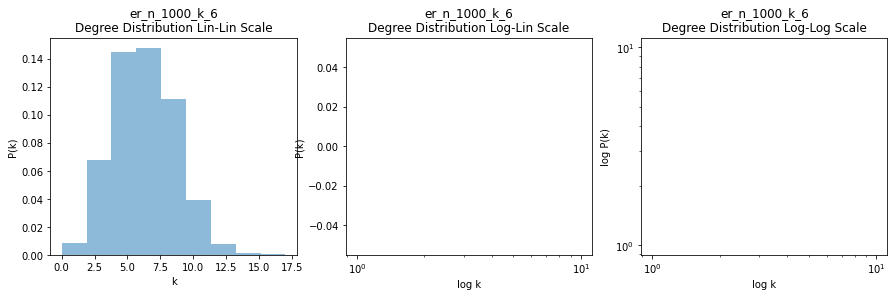

In [ ]:
plot_degree_distributions(er_n_1000_k_6, "er_n_1000_k_6", n_bins=10, density=True)

In [ ]:
er_n_100_k_6 = erdos_renyi_graph_with_average_degree(100, 6)
print(get_average_degree(er_n_100_k_6))

5.96


#### 2.2.2 Barabási-Albert graph
*barabasi_albert_graph(n, m, seed=None)*.  
n ... [int] ... Number of nodes.  
m ... [int] ... Number of edges to attach from a new node to existing nodes.  

In [ ]:
ba_n_1000_k_6 = nx.barabasi_albert_graph(1000, 3)
quantify_graph(ba_n_1000_k_6)

Number of Nodes: 1000
Number of Edges: 2991
Is directed: False
Is weighted: False
Is connected: True
Density: 0.005987987987987988
Diameter: 6
Min Node Degree: 3
Max Node Degree: 78
Average Node Degree: <k> ≈ 5.98
Average Clustering Coefficient: 0.0292
Degree Assortativity Coefficient: -0.1033
Fitted power law-exponent: Ɣ ≈ 2.66
Standard error of fit: σ ≈ 0.0848


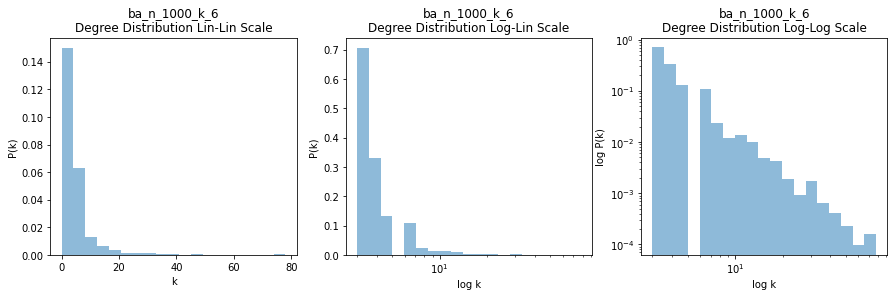

In [ ]:
plot_degree_distributions(ba_n_1000_k_6, "ba_n_1000_k_6", n_bins=20, density=True)

In [ ]:
ba_n_100_k_6 = nx.barabasi_albert_graph(100, 3)
print(get_average_degree(ba_n_100_k_6))

5.82


#### 2.2.3 Watts Strogatz graph
*watts_strogatz_graph(n, k, p, seed=None)*.  
n ... [int] ... The number of nodes.  
k ... [int] ... Each node is connected to k nearest neighbors in ring topology.  
p ... [float] ... The probability of rewiring each edge.  
seed ..[int] ...optional Seed for random number generator (default=None)  


In [ ]:
ws_n_1000_k_6 = nx.watts_strogatz_graph(n=1000, k=6, p=0.5)
quantify_graph(ws_n_1000_k_6)

Number of Nodes: 1000
Number of Edges: 3000
Is directed: False
Is weighted: False
Is connected: True
Density: 0.006006006006006006
Diameter: 7
Min Node Degree: 3
Max Node Degree: 12
Average Node Degree: <k> ≈ 6.0
Average Clustering Coefficient: 0.0852
Degree Assortativity Coefficient: -0.1072
Fitted power law-exponent: Ɣ ≈ 7.08
Standard error of fit: σ ≈ 0.3307


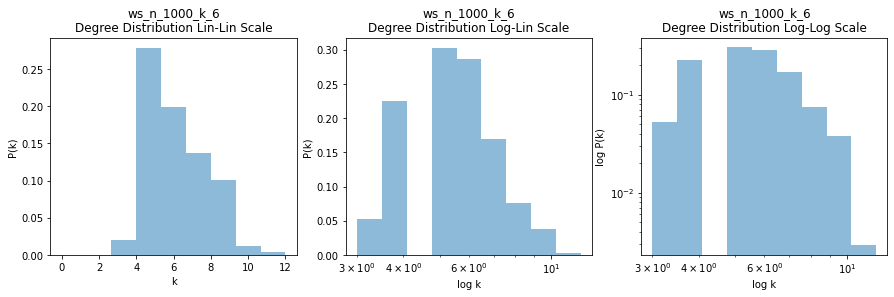

In [ ]:
plot_degree_distributions(ws_n_1000_k_6, "ws_n_1000_k_6", n_bins=10, density=True)

In [ ]:
ws_n_100_k_6 = nx.watts_strogatz_graph(n=100, k=6, p=0.5)
print(get_average_degree(ws_n_100_k_6))

6.0


### 2.3 Real World Graphs
#### 2.3.1 Facebook Graph

In [ ]:
graph_facebook = load_graph("graph_facebook.gml")

Number of Nodes: 4039
Number of Edges: 88234
Is directed: False
Is weighted: False
Is connected: True
Density: 0.010819963503439287
Diameter: 8
Min Node Degree: 1
Max Node Degree: 1045
Average Node Degree: <k> ≈ 43.69
Average Clustering Coefficient: 0.6055
Degree Assortativity Coefficient: 0.0636
Fitted power law-exponent: Ɣ ≈ 2.51
Standard error of fit: σ ≈ 0.0427


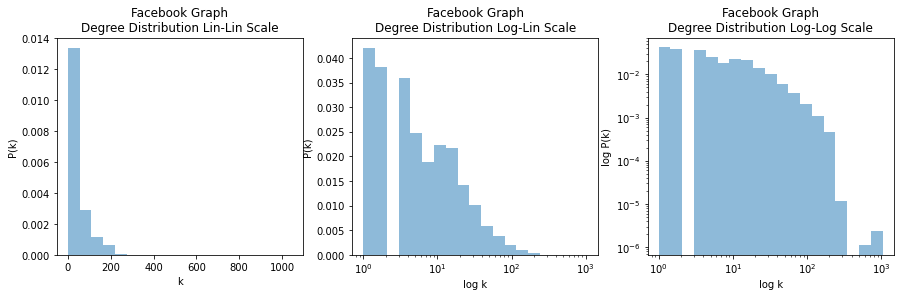

In [ ]:
plot_degree_distributions(graph_facebook, "Facebook Graph", n_bins=20, density=True)

#### 2.3.2 Escorts Graph

In [ ]:
graph_escort = load_graph("graph_escort.gml")

Number of Nodes: 16730
Number of Edges: 39044
Is directed: False
Is weighted: False
Is connected: False
Density: 0.0002790091060628706
Min Node Degree: 1
Max Node Degree: 305
Average Node Degree: <k> ≈ 4.67
Average Clustering Coefficient: 0.0
Degree Assortativity Coefficient: -0.1097
Fitted power law-exponent: Ɣ ≈ 2.87
Standard error of fit: σ ≈ 0.0758


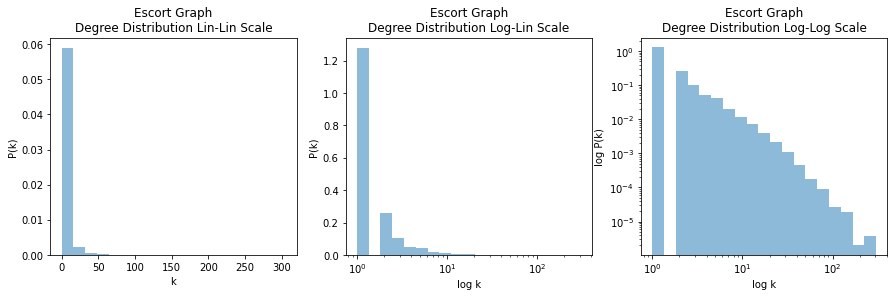

In [ ]:
plot_degree_distributions(graph_escort, "Escort Graph", n_bins=20, density=True)

#### 2.3.3 Jazz Collaborations Graph

In [ ]:
graph_jazz_collab = load_graph("graph_jazz_collab.gml")

Number of Nodes: 198
Number of Edges: 2742
Is directed: False
Is weighted: False
Is connected: True
Density: 0.14059375480695277
Diameter: 6
Min Node Degree: 1
Max Node Degree: 100
Average Node Degree: <k> ≈ 27.7
Average Clustering Coefficient: 0.6175
Degree Assortativity Coefficient: 0.0202
Fitted power law-exponent: Ɣ ≈ 5.27
Standard error of fit: σ ≈ 0.581


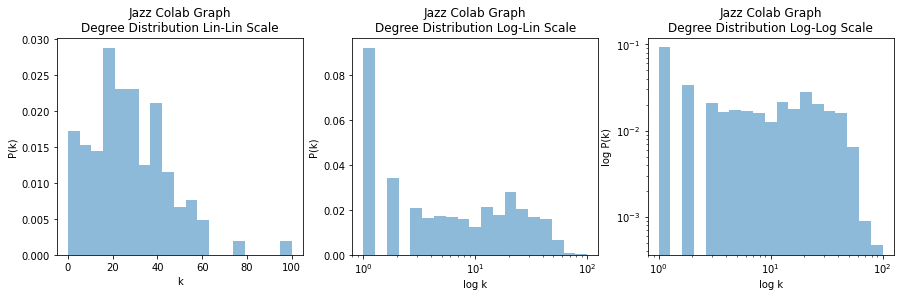

In [ ]:
plot_degree_distributions(graph_jazz_collab, "Jazz Colab Graph", n_bins=20, density=True)

#### 2.3.4 Jazz Collaborations Graph

In [ ]:
graph_florentine_families = load_graph("graph_florentine_families.gml")

Number of Nodes: 15
Number of Edges: 27
Is directed: False
Is weighted: False
Is connected: True
Density: 0.2571428571428571
Diameter: 4
Min Node Degree: 1
Max Node Degree: 8
Average Node Degree: <k> ≈ 3.6
Average Clustering Coefficient: 0.4429
Degree Assortativity Coefficient: -0.4786
Fitted power law-exponent: Ɣ ≈ 5.03
Standard error of fit: σ ≈ 1.4252


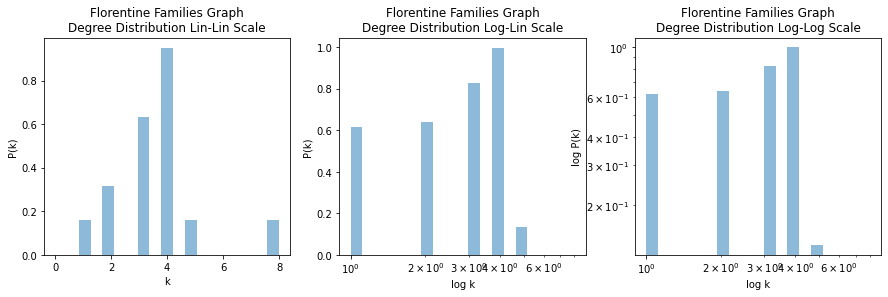

In [ ]:
plot_degree_distributions(graph_florentine_families, "Florentine Families Graph", n_bins=20, density=True)

#### 2.3.5 Haslemere Contact Tracing Graph

In [ ]:
def read_haslemere_graph():
  # First we read the CSV: Contact tracing data over 3 days
  tracing_df = pd.read_csv("https://raw.githubusercontent.com/skissler/haslemere/master/Kissler_DataS1.csv")
  tracing_df.info()
  tracing_graph = nx.Graph()
  # Then we add for every contact <= 5m an edge with the attribute distance that shows the exact distance
  for index, row in tracing_df.iterrows():
      if row[3] <= 5 and not tracing_graph.has_edge(row[1], row[2]):
        tracing_graph.add_edge(int(row[1]), int(row[2]), distance=row[3], timestep=row[0])
  return tracing_graph
graph_haslemere = read_haslemere_graph()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102830 entries, 0 to 102829
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   1       102830 non-null  int64
 1   1.1     102830 non-null  int64
 2   390     102830 non-null  int64
 3   17      102830 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


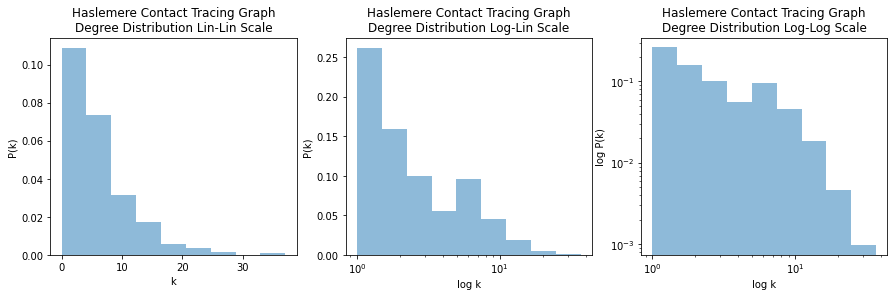

In [ ]:
plot_degree_distributions(graph_haslemere, "Haslemere Contact Tracing Graph", n_bins=10, density=True)

### 3.1 Experiment 1

In [12]:
def gillespie_wellmixed(N, recovery_rate, initial_infectionrate,r):
    # creating 20 values between 0 and 0.3
    betas = np.linspace(0,0.3,20)
    
    avg_fraction_per_beta = []
    
    for beta in betas:
        R_per_run = []  

        for i in range (0,r):
            S_Init = np.zeros(int(N-N*initial_infectionrate),dtype=int)
            I_Init = np.ones(int(N*initial_infectionrate),dtype=int)
            populationvector = np.append(S_Init,I_Init)
            np.random.shuffle(populationvector)
            time = 0

            while np.sum( populationvector == 1 ) > 0:
                # calculating aggregated infection and recovery rates
                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate
                next_event = -np.log(rnd.random()) / total_rate
                time += next_event

                if rnd.random() < (infection_rate / total_rate):
                    # infection takes place
                    index_S = np.where(populationvector == 0)
                    populationvector[index_S[0][0]] = 1

                else:
                    # recovery takes place
                    index_infected = np.where(populationvector == 1) 
                    populationvector[index_infected[0][0]] = 2            

                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate


            S= np.sum( populationvector == 0 )
            I= np.sum( populationvector == 1 )
            R= np.sum( populationvector == 2 )
            #print(time,S,I,R)
            R_per_run.append(R)
            
        avg_fraction_per_beta.append(np.mean(R_per_run)/N)
        
    #print(avg_fraction_per_beta)
    
    plt.plot(betas, avg_fraction_per_beta)   
    plt.title('Final fraction of recovered agents')
    plt.xlabel("β (Infection rate)")
    plt.ylabel("Fraction of recovered agents")
    plt.ylim(0, 1)
    plt.show()     

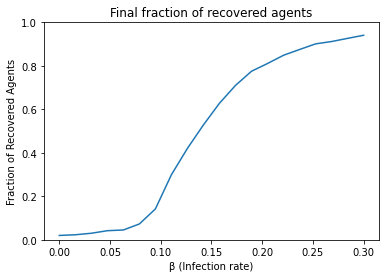

In [11]:
gillespie_wellmixed(1000,0.1,0.02,20)

## 3. Experiments

### 3.1 Unweighted Networks

#### 3.1.1 SIR Epidemic


In [ ]:
    """This function is used in order to simulate mutiple 
    SIR epidemics on the same graph using different
    infection and recovery rates

  Args:
      param1 (int): The first parameter.
      param2 (str): The second parameter.

  Returns:
      bool: The return value. True for success, False otherwise.

  .. _PEP 484:
      https://www.python.org/dev/peps/pep-0484/
  """
def simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=1, tmin=DEFAULT_TMIN, tmax=DEFAULT_TMAX):
  return EoN.Gillespie_SIR(graph, infection_rate, recovery_rate, initial_infecteds = range(initital_size), tmin=tmin, tmax=tmax)

In [ ]:
def plot_SIR_epidemic(t, S, I, R, title):
  plt.title(title)
  plt.plot(t, S, color="blue", linestyle='dotted', label = 'Susceptible')
  plt.plot(t, I, color="red", linestyle='dashed', label = 'Infected')
  plt.plot(t, R, color="green", linestyle='solid', label = 'Recovered')
  plt.xlabel('$t$')
  plt.ylabel('Number of People')
  plt.legend()  
  plt.show()

In [ ]:
def simulate_SIR_epidemics(graph, infection_rates, recovery_rates, initial_size=1, tmax=TMAX):
  """This function is used in order to simulate mutiple 
    SIR epidemics on the same graph using different
    infection and recovery rates

  Args:
      graph (int): The first parameter.
      infection_rates (str): The second parameter.
      recovery_rates (str): The second parameter.
      initial_size (int): The number of people initially infected with the disease.

  Returns:
      bool: The return value. True for success, False otherwise.

  .. _PEP 484:
      https://www.python.org/dev/peps/pep-0484/

  """
  
  n_i = len(infection_rates)
  n_r = len(recovery_rates)

  results = np.empty([n_i, n_r], dtype=object)
  result_dict = {}

  for i in range(n_i):
    infection_rate = infection_rates[i]
    result_dict[infection_rate] = {}
    for r in range(n_r):
      recovery_rate = recovery_rates[r]
      t, S, I, R = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmax=tmax)
      results[i][r] = (t, S, I, R)
      result_dict[infection_rate][recovery_rate] = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmax=tmax)
  return results

In [ ]:
def plot_SIR_epidemics(graph_name, infection_rates, recovery_rates, results):
  n_i = len(infection_rates)
  n_r = len(recovery_rates)
  fig, axs = plt.subplots(n_i, n_r, figsize=(16,12))
  fig.suptitle("Simulation of SIR Epidemics on {}".format(graph_name), fontsize=14)
  for i in range(n_i):
    infection_rate = infection_rates[i]
    for r in range(n_r):
      recovery_rate = recovery_rates[r]
      t, S, I, R = results[i][r]
      axs[i, r].plot(t, S, color=S_COLOR, linestyle=S_LINESTYLE, label = S_LABEL)
      axs[i, r].plot(t, I, color=I_COLOR, linestyle=I_LINESTYLE, label = I_LABEL)
      axs[i, r].plot(t, R, color=R_COLOR, linestyle=R_LINESTYLE, label = R_LABEL)
      axs[i, r].title.set_text("β: {}, γ: {}".format(infection_rate, recovery_rate))

In [ ]:
def compare_SIR_epidemics(graph_name, infection_rates, recovery_rates, results):
  '''
  This function is supposed to print the S, I, R curves of different simulations 
  in one plot, in order to make the curves better comparable
  '''
  n_i = len(infection_rates)
  n_r = len(recovery_rates)
  # Create four polar axes and access them through the returned array
  fig, axs = plt.subplots(1, 3, figsize=(12,8))
  fig.figsize=(6, 18)
  #axs[0, 0].plot(x, y)
  #axs[1, 1].scatter(x, y)
  for i in range(n_i):
    infection_rate = infection_rates[i]
    for r in range(n_r):
      recover_rate = recovery_rates[i]
      t, S, I, R = results[i][r]
      axs[0].plot(t, S, color="blue", linestyle='dotted', label = 'Susceptible')
      axs[1].plot(t, I, color="red", linestyle='dashed', label = 'Infected')
      axs[2].plot(t, R, color="green", linestyle='solid', label = 'Recovered')

In [ ]:
def simulate_SIR_epidemics_dif_params(graph, parameter_combinations):
  for parameter_combination in parameter_combinations:
    infection_rate = parameter_combination.get("infection_rate", DEFAULT_INFECTION_RATE)
    recovery_rate = parameter_combination.get("recovery_rate", DEFAULT_RECOVERY_RATE)
    tmin = parameter_combination.get("tmin", DEFAULT_TMIN) 
    tmax = parameter_combination.get("tmax", DEFAULT_TMAX)
    initial_size = parameter_combination.get("initial_size", DEFAULT_INITIAL_SIZE)

    t, S, I, R = simulate_SIR_epidemic(graph, infection_rate, recovery_rate, initital_size=initial_size, tmin=tmin, tmax=tmax)
    plot_SIR_epidemic(t, S, I, R, "β: {}, γ: {}".format(infection_rate, recovery_rate))

In [ ]:
def SIR_network_comparison(network_01, name_01, network_02, name_02, parameter_combinations):
    for parameter_combination in parameter_combinations:
      infection_rate = parameter_combination.get("infection_rate", DEFAULT_INFECTION_RATE)
      recovery_rate = parameter_combination.get("recovery_rate", DEFAULT_RECOVERY_RATE)
      tmin = parameter_combination.get("tmin", DEFAULT_TMIN) 
      tmax = parameter_combination.get("tmax", DEFAULT_TMAX)
      initial_size = parameter_combination.get("initial_size", DEFAULT_INITIAL_SIZE)
      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      plt.setp(axs, ylim=(0,1))
      #fig.figsize=(12, 6)
      N1 = network_01.number_of_nodes()
      N2 = network_02.number_of_nodes()

      t1, S1, I1, R1 = EoN.Gillespie_SIR(network_01, infection_rate, recovery_rate, initial_infecteds = range(initial_size), tmax=tmax)
      t2, S2, I2, R2 = EoN.Gillespie_SIR(network_02, infection_rate, recovery_rate, initial_infecteds = range(initial_size), tmax=tmax)
      #plot_SIR_epidemic(t, S, I, R, "β: {}, γ: {}".format(infection_rate, recovery_rate))

      axs[0].plot(t1, S1/N1, color=S_COLOR, linestyle='dotted', label = 'Susceptible')
      axs[0].plot(t1, I1/N1, color=I_COLOR, linestyle='dashed', label = 'Infected')
      axs[0].plot(t1, R1/N1, color=R_COLOR, linestyle='solid', label = 'Recovered')
      axs[0].title.set_text("Network: {0} \n Disease: β={1}, γ={2}".format(name_01, infection_rate, recovery_rate))

      axs[1].plot(t2, S2/N2, color=S_COLOR, linestyle='dotted', label = 'Susceptible')
      axs[1].plot(t2, I2/N2, color=I_COLOR, linestyle='dashed', label = 'Infected')
      axs[1].plot(t2, R2/N2, color=R_COLOR, linestyle='solid', label = 'Recovered')
      axs[1].title.set_text("Network: {0} \n Disease: β={1}, γ={2}".format(name_02, infection_rate, recovery_rate))

      #plt.xlim([0, TMIN])
      #plt.show()

### Compare T, S, I, R

In [ ]:
# TODO: discuss whether we should also generate the new graph in the loop?
def get_averaged_values_sir(gr, infection_rate=0.5, recovery_rate=1.0, n_iter=10, t_max=10, n_initial_infected = 5, print_prog=False):
  T_VALUES = []
  S_VALUES = [] 
  I_VALUES = []
  R_VALUES = []
  all_nodes = list(gr.nodes)

  for i in range(n_iter):
    shuffle(all_nodes)
    t, S, I, R = EoN.Gillespie_SIR(gr, infection_rate, recovery_rate, initial_infecteds = all_nodes[:n_initial_infected], tmax=t_max)
    T_VALUES.append(max(t))
    S_VALUES.append(min(S))
    I_VALUES.append(max(I))
    R_VALUES.append(max(R))
    if print_prog:
      print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))
  
  return np.array(T_VALUES).mean(), np.array(T_VALUES).std(), np.array(S_VALUES).mean(), np.array(S_VALUES).std(), np.array(I_VALUES).mean(), np.array(I_VALUES).std(), np.array(R_VALUES).mean(), np.array(R_VALUES).std()

#### Haslemere

In [ ]:
hm_avg_t, hm_std_t, hm_avg_s, hm_std_s, hm_avg_i, hm_std_i, hm_avg_r, hm_std_r = get_averaged_values_sir(graph_haslemere, n_iter=100, infection_rate=0.3)
print(hm_avg_t, hm_std_t, hm_avg_s, hm_std_s, hm_avg_i, hm_std_i, hm_avg_r, hm_std_r)

8.956087552560797 1.656362298856076 193.27 51.36143592229486 64.49 17.94853475913842 222.67 51.16601508814225


In [ ]:
graph_ba_hm = nx.barabasi_albert_graph(len(graph_haslemere.nodes), int(len(graph_haslemere.edges) / len(graph_haslemere.nodes)))
ba_avg_t, ba_std_t, ba_avg_s, ba_std_s, ba_avg_i, ba_std_i, ba_avg_r, ba_std_r = get_averaged_values_sir(graph_ba_hm, n_iter=100, infection_rate=0.3)
print(ba_avg_t, ba_std_t, ba_avg_s, ba_std_s, ba_avg_i, ba_std_i, ba_avg_r, ba_std_r)

8.967800137114123 1.8787562540210463 207.24 60.90535608630821 56.44 18.380598466861738 207.37 61.27016484391078


In [ ]:
graph_ws_hm = nx.watts_strogatz_graph(len(graph_haslemere.nodes), int(len(graph_haslemere.edges) / len(graph_haslemere.nodes)), 0.5)
ws_avg_t, ws_std_t, ws_avg_s, ws_std_s, ws_avg_i, ws_std_i, ws_avg_r, ws_std_r = get_averaged_values_sir(graph_ws_hm, n_iter=100, infection_rate=0.3)
print(ws_avg_t, ws_std_t, ws_avg_s, ws_std_s, ws_avg_i, ws_std_i, ws_avg_r, ws_std_r)

3.062090778603265 1.6370811376605623 409.82 2.3211204191079795 5.86 0.990151503558925 8.17 2.3110819976798744


In [ ]:
print(tabulate([
                ["Haslemere", hm_avg_t, hm_avg_s, hm_avg_i, hm_avg_r],
                ["Barabasi Albert", ba_avg_t, ba_avg_s, ba_avg_i, ba_avg_r],
                ["Watts Strogatz", ws_avg_t, ws_avg_s, ws_avg_i, ws_avg_r]
                ], headers=["Network", "Max t", "Max S", "Max I", "Max R"]))

Network            Max t    Max S    Max I    Max R
---------------  -------  -------  -------  -------
Haslemere        8.95609   193.27    64.49   222.67
Barabasi Albert  8.9678    207.24    56.44   207.37
Watts Strogatz   3.06209   409.82     5.86     8.17


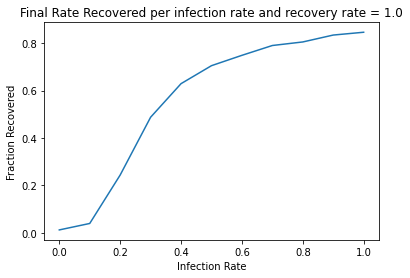

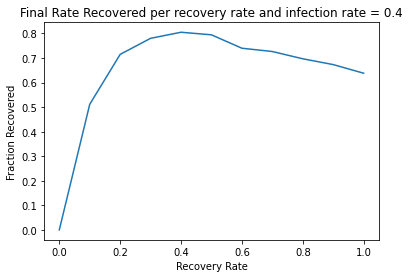

In [ ]:
def plot_inf_rate_vs_final_r(graph, inf_rates = [i * 0.1 for i in range(11)]):
  final_rs = []
  for inf_rate in inf_rates:
    gr_avg_t, gr_std_t, gr_avg_s, gr_std_s, gr_avg_i, gr_std_i, gr_avg_r, gr_std_r = get_averaged_values_sir(graph, n_iter=100, infection_rate=inf_rate)
    final_rs.append(gr_avg_r / len(list(graph.nodes)))
  plt.plot(inf_rates, final_rs)
  plt.title("Final Rate Recovered per infection rate and recovery rate = 1.0")
  plt.xlabel("Infection Rate")
  plt.ylabel("Fraction Recovered")
  plt.show()

def plot_rec_rate_vs_final_r(graph, rec_rates = [i * 0.1 for i in range(11)]):
  final_rs = []
  for rec_rate in rec_rates:
    gr_avg_t, gr_std_t, gr_avg_s, gr_std_s, gr_avg_i, gr_std_i, gr_avg_r, gr_std_r = get_averaged_values_sir(graph, n_iter=100, recovery_rate=rec_rate, infection_rate=0.4)
    final_rs.append(gr_avg_r / len(list(graph.nodes)))
  plt.plot(rec_rates, final_rs)
  plt.title("Final Rate Recovered per recovery rate and infection rate = 0.4")
  plt.xlabel("Recovery Rate")
  plt.ylabel("Fraction Recovered")
  plt.show()

plot_inf_rate_vs_final_r(graph_haslemere)
plot_rec_rate_vs_final_r(graph_haslemere)



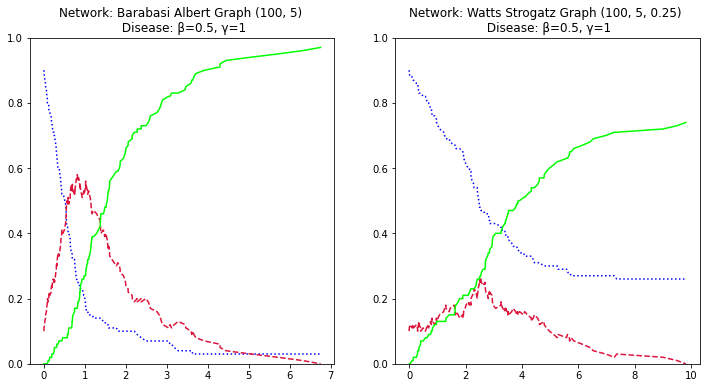

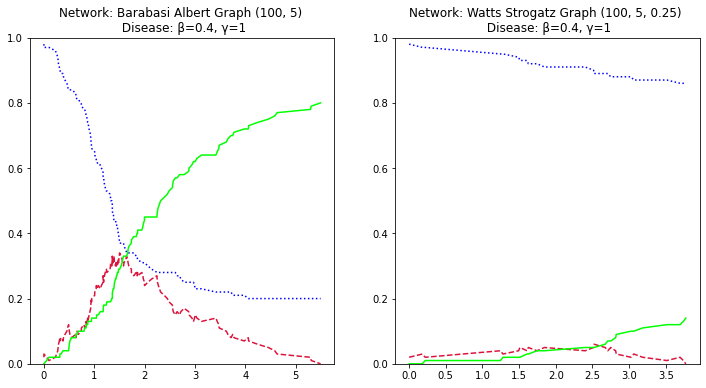

In [ ]:
#infection_rates = [0.3, 0.6, 0.9]
#recovery_rates = [0.6, 0.9, 1.2]
#results = simulate_SIR_epidemics(barabasi_albert_graph_small, infection_rates, recovery_rates, tmax=TMAX);
#plot_SIR_epidemics("Barabasi Albert Graph (100, 5)", infection_rates, recovery_rates, results)
parameter_combinations = [
  {"infection_rate": 0.5, "recovery_rate": 1, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},
  {"infection_rate": 0.4, "recovery_rate": 1, "tmin": TMIN, "tmax":TMAX, "initial_size": 2},
]
barabasi_albert_graph_small = nx.barabasi_albert_graph(100,5)
watts_strogatz_graph_small = nx.watts_strogatz_graph(100,5, 0.25)
SIR_network_comparison(barabasi_albert_graph_small, "Barabasi Albert Graph (100, 5)", watts_strogatz_graph_small, "Watts Strogatz Graph (100, 5, 0.25)", parameter_combinations)

In [ ]:
infection_rate=0.
recovery_rate=1
initial_infecteds=range(10)
tmax=20

T_VALUES = []
S_VALUES = [] 
I_VALUES = []
R_VALUES = []
for i in range(10):
  sim = EoN.Gillespie_SIR(ba_n_1000_k_6, infection_rate, recovery_rate, return_full_data=True, initial_infecteds = initial_infecteds , tmax=tmax)
  T = sim.t()
  MAX_T = np.max(T)
  T_VALUES.append(MAX_T)
  S = sim.S()
  MIN_S = np.min(S)
  S_VALUES.append(MIN_S)
  I = sim.I()
  MAX_I = np.max(I)
  I_VALUES.append(MAX_I)
  R = sim.R()
  MAX_R = np.max(R)
  R_VALUES.append(MAX_R)
  print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))

AVG_MAX_T = average(T_VALUES)
AVG_MIN_S = average(S_VALUES)
AVG_MAX_I = average(I_VALUES)
AVG_MAX_R = average(R_VALUES)
print("Avg Max T: {}, Avg Min S: {}, Avg Max I: {}, Avg Max R: {}".format(AVG_MAX_T, AVG_MIN_S, AVG_MAX_I, AVG_MAX_R))

Simulation 0 => Max T: 12.579676312224832, Min S: 713, Max I: 74, Max R: 287
Simulation 1 => Max T: 9.228875531231036, Min S: 656, Max I: 100, Max R: 344
Simulation 2 => Max T: 9.032260523289352, Min S: 666, Max I: 108, Max R: 334
Simulation 3 => Max T: 10.530956088601547, Min S: 706, Max I: 72, Max R: 294
Simulation 4 => Max T: 14.219965366217961, Min S: 678, Max I: 55, Max R: 322
Simulation 5 => Max T: 11.868227017026156, Min S: 662, Max I: 89, Max R: 338
Simulation 6 => Max T: 7.894244016775498, Min S: 624, Max I: 102, Max R: 376
Simulation 7 => Max T: 13.013996425493596, Min S: 605, Max I: 90, Max R: 395
Simulation 8 => Max T: 15.948528867781485, Min S: 573, Max I: 113, Max R: 427
Simulation 9 => Max T: 8.591611223775946, Min S: 712, Max I: 83, Max R: 288
Avg Max T: 11.290834137241742, Avg Min S: 659.5, Avg Max I: 88.6, Avg Max R: 340.5


In [ ]:
infection_rate=0.2
recovery_rate=1
initial_infecteds=range(10)
tmax=20

T_VALUES = []
S_VALUES = [] 
I_VALUES = []
R_VALUES = []
for i in range(10):
  sim = EoN.Gillespie_SIR(er_n_1000_k_6, infection_rate, recovery_rate, return_full_data=True, initial_infecteds = initial_infecteds , tmax=tmax)
  T = sim.t()
  MAX_T = np.max(T)
  T_VALUES.append(MAX_T)
  S = sim.S()
  MIN_S = np.min(S)
  S_VALUES.append(MIN_S)
  I = sim.I()
  MAX_I = np.max(I)
  I_VALUES.append(MAX_I)
  R = sim.R()
  MAX_R = np.max(R)
  R_VALUES.append(MAX_R)
  print("Simulation {} => Max T: {}, Min S: {}, Max I: {}, Max R: {}".format(i, MAX_T, MIN_S, MAX_I, MAX_R))

N_NODES = er_n_1000_k_6.number_of_nodes
AVG_MAX_T = average(T_VALUES) / N_NODES
AVG_MIN_S = average(S_VALUES) / N_NODES
AVG_MAX_I = average(I_VALUES) / N_NODES
AVG_MAX_R = average(R_VALUES) / N_NODES

print("Avg Max T: {}, Avg Min S: {}, Avg Max I: {}, Avg Max R: {}".format(AVG_MAX_T, AVG_MIN_S, AVG_MAX_I, AVG_MAX_R))

Simulation 0 => Max T: 10.056634216395755, Min S: 906, Max I: 21, Max R: 94
Simulation 1 => Max T: 17.736386914308536, Min S: 759, Max I: 29, Max R: 241
Simulation 2 => Max T: 4.060297486542938, Min S: 974, Max I: 17, Max R: 26
Simulation 3 => Max T: 3.176392281002847, Min S: 978, Max I: 12, Max R: 22
Simulation 4 => Max T: 13.057222115836591, Min S: 912, Max I: 17, Max R: 88
Simulation 5 => Max T: 7.640861576917663, Min S: 965, Max I: 13, Max R: 35
Simulation 6 => Max T: 10.548914924722636, Min S: 868, Max I: 27, Max R: 132
Simulation 7 => Max T: 10.992578914452759, Min S: 910, Max I: 16, Max R: 90
Simulation 8 => Max T: 9.540719810763186, Min S: 942, Max I: 13, Max R: 58
Simulation 9 => Max T: 6.9350838344728345, Min S: 970, Max I: 10, Max R: 30


TypeError: ignored

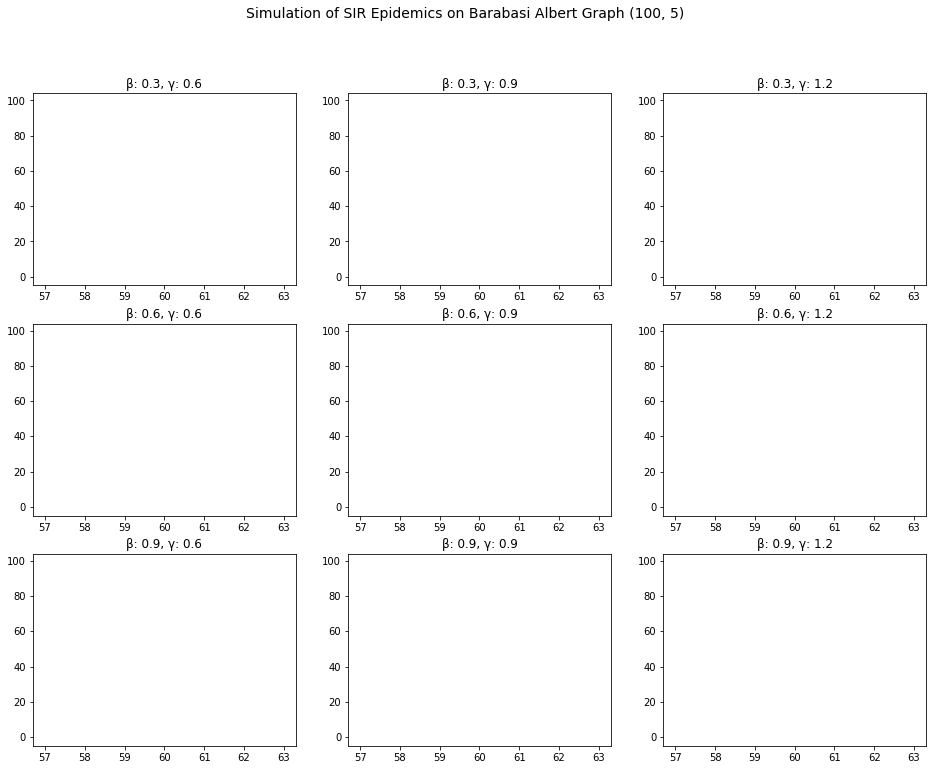

In [ ]:
infection_rates = [0.3, 0.6, 0.9]
recovery_rates = [0.6, 0.9, 1.2]
results = simulate_SIR_epidemics(barabasi_albert_graph_small, infection_rates, recovery_rates, tmax=TMAX);
plot_SIR_epidemics("Barabasi Albert Graph (100, 5)", infection_rates, recovery_rates, results)

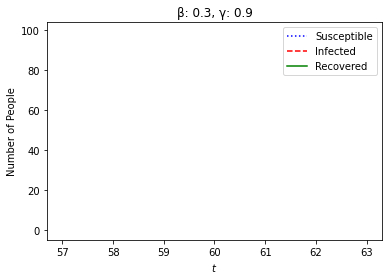

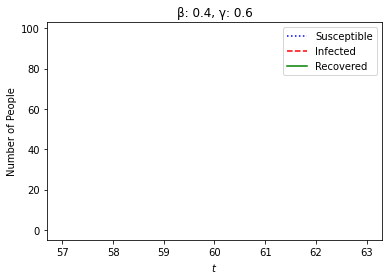

In [ ]:
parameter_combinations = [
  {"infection_rate": 0.3, "recovery_rate": 0.9, "tmin": TMIN, "tmax":TMAX, "initial_size": 1},
  {"infection_rate": 0.4, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 2},
]
results = simulate_SIR_epidemics_dif_params(barabasi_albert_graph_small, parameter_combinations);

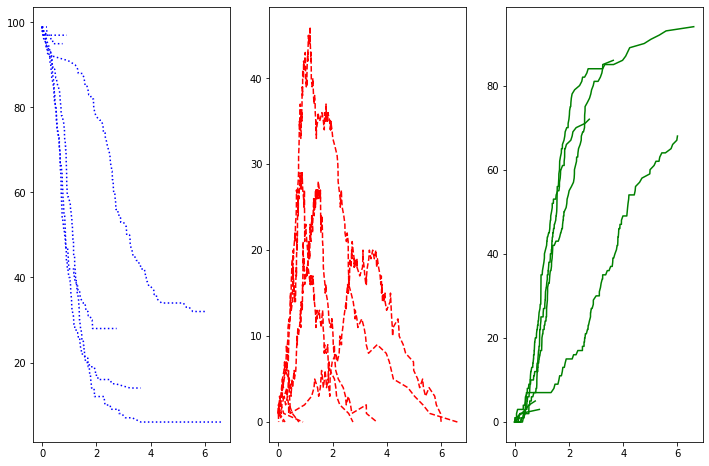

In [ ]:
compare_SIR_epidemics("graph", infection_rates, recovery_rates, results)

The peak of infected people is 10719


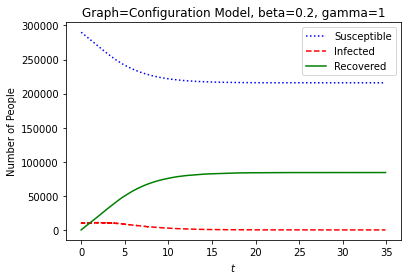

The peak of infected people is 49087


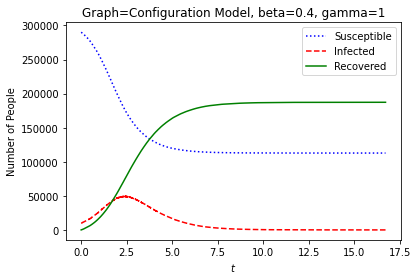

The peak of infected people is 80248


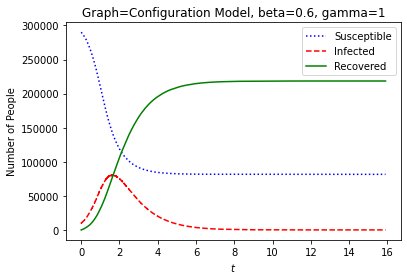

In [ ]:
G = nx.configuration_model([1,5,10]*100000)
initial_size = 10000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Configuration Model", infection_rate, recovery_rate))

The peak of infected people is 18010


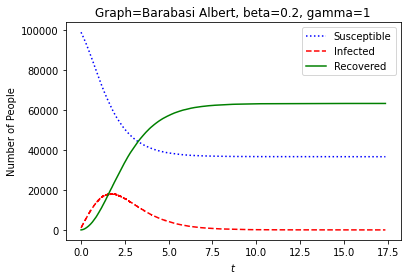

The peak of infected people is 37128


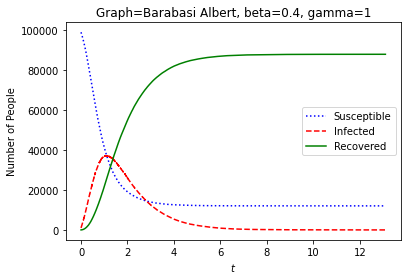

The peak of infected people is 48099


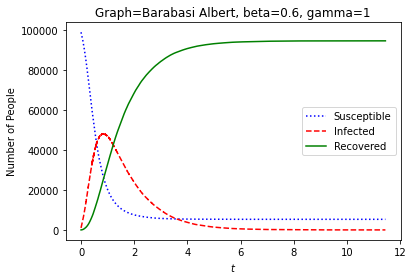

In [ ]:
G = nx.barabasi_albert_graph(10**5, 5)
initial_size = 1000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Barabasi Albert", infection_rate, recovery_rate))

In [ ]:
erdos_renyi_graph(n, p, seed=None, directed=False)
G = nx.barabasi_albert_graph(10**5, 5)
initial_size = 1000

recovery_rate = 1
infection_rates = np.linspace(0.2, 0.6, 3)
for infection_rate in infection_rates: # infection rate
  t, S, I, R = simulate_SIR_epidemic(G, infection_rate, recovery_rate, initial_size)
  print("The peak of infected people is {}".format(np.amax(I)))
  plot_SIR_epidemic(t, S, I, R, "Graph={}, beta={}, gamma={}".format("Barabasi Albert", infection_rate, recovery_rate))

#### Experiment 01

In [ ]:
er_n_1000_k_6 = erdos_renyi_graph_with_average_degree(1000, 6)
print(compute_average_degree(er_n_1000_k_6))
ba_n_1000_k_6 = nx.barabasi_albert_graph(100, 3)
print(compute_average_degree(ba_n_1000_k_6))

5.864
5.82


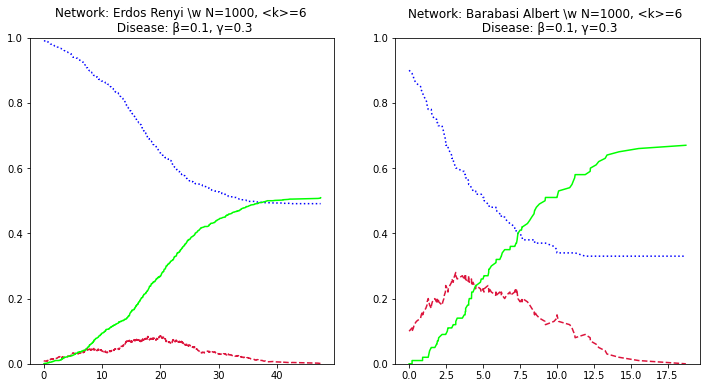

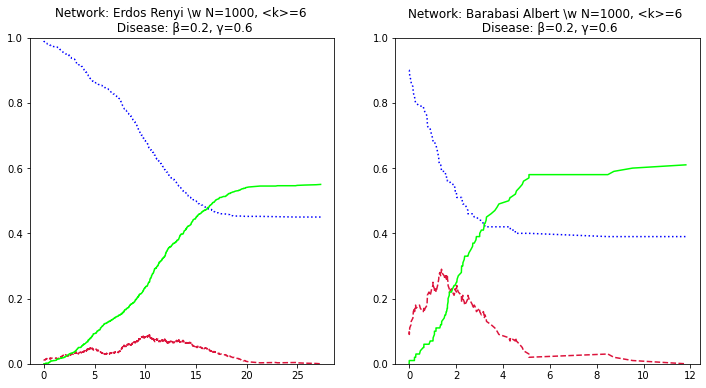

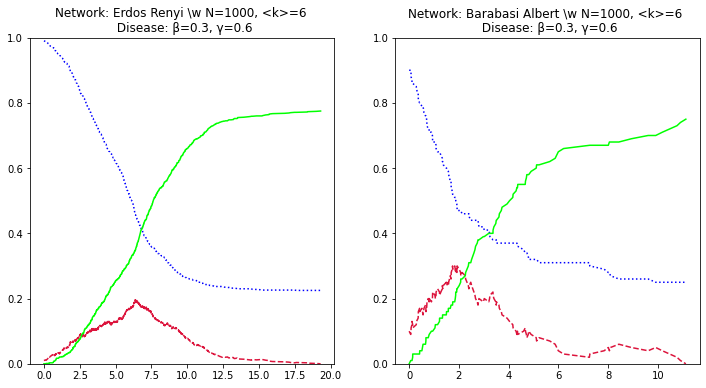

In [ ]:
#analyze_graph(er_n_1000_k_6)
#analyze_graph(ba_n_1000_k_6)

parameter_combinations = [
  {"infection_rate": 0.1, "recovery_rate": 0.3, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},
  {"infection_rate": 0.2, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},#
  {"infection_rate": 0.3, "recovery_rate": 0.6, "tmin": TMIN, "tmax":TMAX, "initial_size": 10},#
]
SIR_network_comparison(er_n_1000_k_6, "Erdos Renyi \w N=1000, <k>=6", ba_n_1000_k_6, "Barabasi Albert \w N=1000, <k>=6",  parameter_combinations)

### 3.1.2 SEIR Epidemic

generating graph G with 100000 nodes
doing Gillespie simulation
done with simulation, now plotting


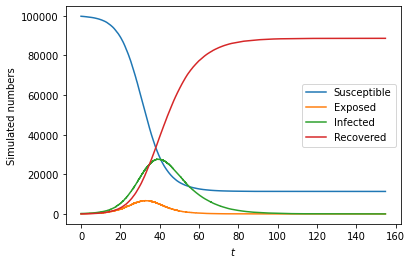

In [ ]:
N = 100000
print('generating graph G with {} nodes'.format(N))
G = nx.fast_gnp_random_graph(N, 5./(N-1))
#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5+random.random() for node in G.nodes()}
edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()}
nx.set_node_attributes(G, values=node_attribute_dict,
                        name='expose2infect_weight')
nx.set_edge_attributes(G, values=edge_attribute_dict,
                        name='transmission_weight')
#
#These individual and partnership attributes will be used to scale
#the transition rates.  When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.
#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node('S') #This line is actually unnecessary.
H.add_edge('E', 'I', rate = 0.6, weight_label='expose2infect_weight') 
H.add_edge('I', 'R', rate = 0.1)
J = nx.DiGraph() #for the induced transitions 
J.add_edge(('I', 'S'), ('I', 'E'), rate = 0.1, weight_label='transmission_weight')
IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'
return_statuses = ('S', 'E', 'I', 'R')
print('doing Gillespie simulation')
t, S, E, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses,
                                        tmax = float('Inf'))
print('done with simulation, now plotting')
plt.plot(t, S, label = 'Susceptible')
plt.plot(t, E, label = 'Exposed')
plt.plot(t, I, label = 'Infected')
plt.plot(t, R, label = 'Recovered')
plt.xlabel('$t$')
plt.ylabel('Simulated numbers')
plt.legend()
plt.show()

### 3.1.3 SIRS Epidemic

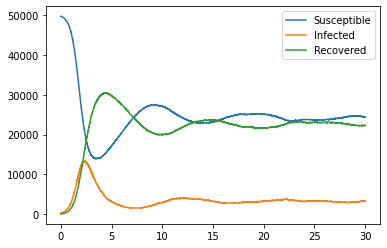

In [ ]:
N = 50000
G = nx.fast_gnp_random_graph(N, 5./(N-1))

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 1.4)   #I->R
H.add_edge('R', 'S', rate = 0.2)   #R->S

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 1)  #IS->II

IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30)

plt.plot(t, S, label = 'Susceptible')
plt.plot(t, I, label = 'Infected')
plt.plot(t, R, label = 'Recovered')
plt.legend()
#plt.savefig('SIRS.png')

#### <<< STABLE PART ENDS HERE <<<
#### >>> EXPERIMENTAL PART BEGINS HERE >>> 

In [ ]:
N = 1.5*10**6 #number of individuals
kave = 5 #expected number of partners
print('generating graph G with {} nodes'.format(N))
G = nx.fast_gnp_random_graph(N, kave/(N-1)) #Erdo''s-Re'nyi graph
rho = 0.005
tau = 0.3
gamma = 1.0
#initial fraction infected
#transmission rate
#recovery rate
print('doing event-based simulation')
t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, rho=rho)
#instead of rho, we could specify a list of nodes as initial_infecteds, or #specify neither and a single random node would be chosen as the index case.
print('doing Gillespie simulation')
t2, S2, I2, R2 = EoN.Gillespie_SIR(G, tau, gamma, rho=rho)
print('done with simulations, now plotting')
plt.plot(t1, I1, label = 'fast_SIR')
plt.plot(t2, I2, label = 
         'Gillespie_SIR')
plt.xlabel('$t$')
plt.ylabel('Number infected')
plt.legend()
plt.show()

ModuleNotFoundError: ignored

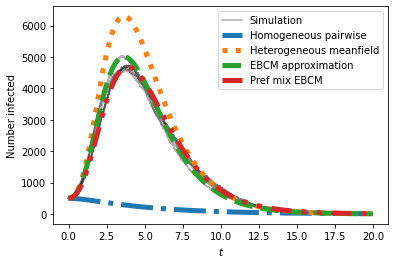

In [ ]:
N=10**5
G=nx.barabasi_albert_graph(N, 5) #create a barabasi-albert graph

tmax = 20
iterations = 5  #run 5 simulations
tau = 0.1           #transmission rate
gamma = 1.0    #recovery rate
rho = 0.005      #random fraction initially infected

for counter in range(iterations): #run simulations
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if counter == 0:
        plt.plot(t, I, color = 'k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color = 'k', alpha=0.3)

#Now compare with ODE predictions.  Read in the degree distribution of G
#and use rho to initialize the various model equations.
#There are versions of these functions that allow you to specify the
#initial conditions rather than starting from a graph.

#we expect a homogeneous model to perform poorly because the degree
#distribution is very heterogeneous
t, S, I, R = EoN.SIR_homogeneous_pairwise_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '-.', label = 'Homogeneous pairwise', linewidth = 5)

#meanfield models will generally overestimate SIR growth because they
#treat partnerships as constantly changing.
t, S, I, R = EoN.SIR_heterogeneous_meanfield_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, ':', label = 'Heterogeneous meanfield', linewidth = 5)

#The EBCM model does not account for degree correlations or clustering
t, S, I, R = EoN.EBCM_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '--', label = 'EBCM approximation', linewidth = 5)

#the preferential mixing model captures degree correlations.
t, S, I, R = EoN.EBCM_pref_mix_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, label = 'Pref mix EBCM', linewidth=5, dashes=[4, 2, 1, 2, 1, 2])

plt.xlabel('$t$')
plt.ylabel('Number infected')

plt.legend()
plt.savefig('SIR_BA_model_vs_sim.png')

doing Gillespie simulation
done with simulation, now plotting


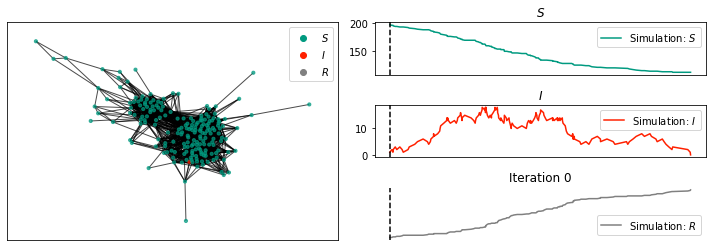

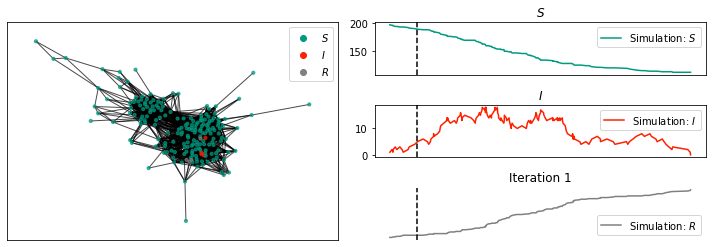

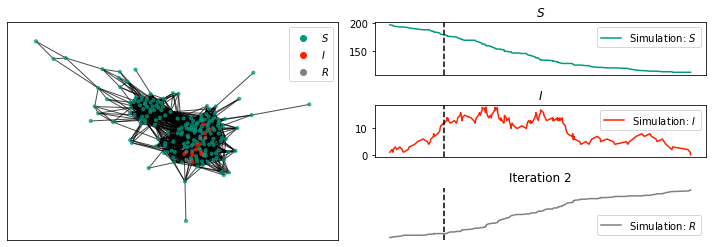

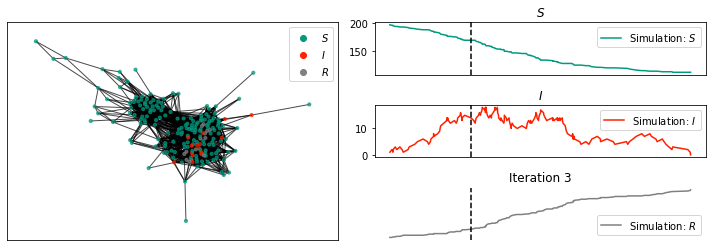

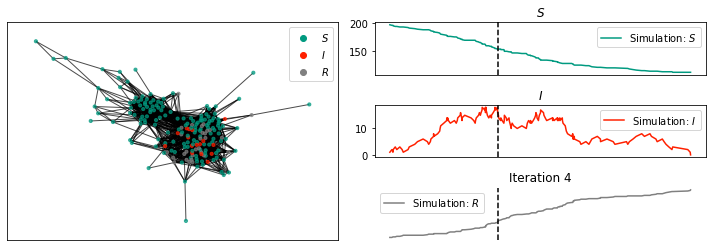

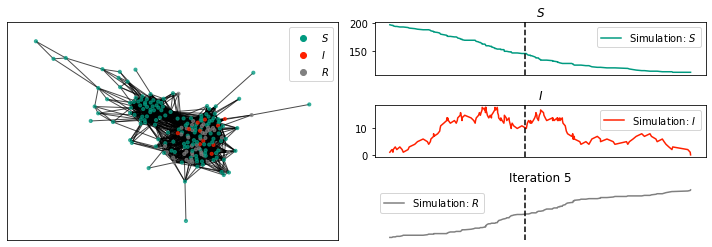

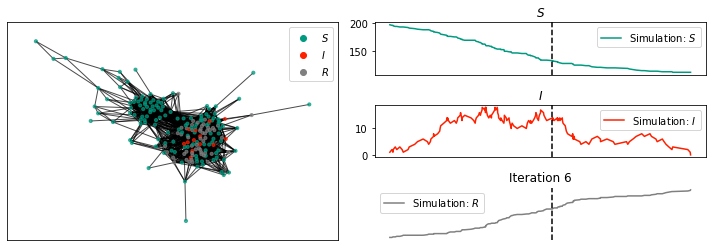

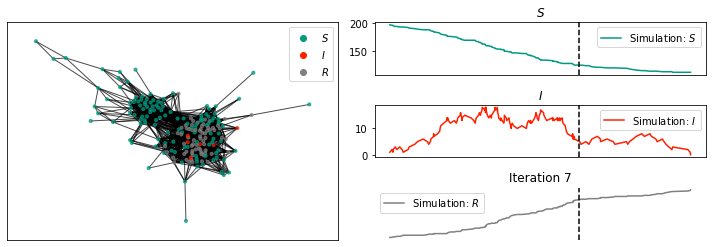

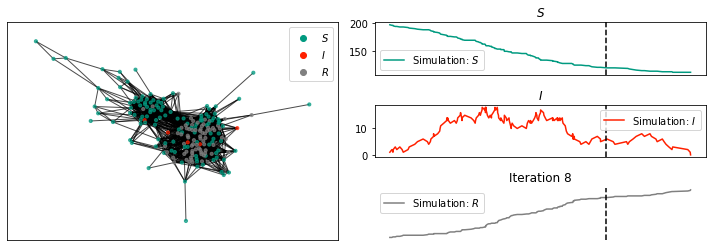

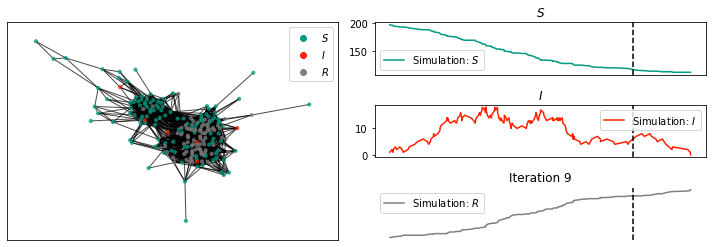

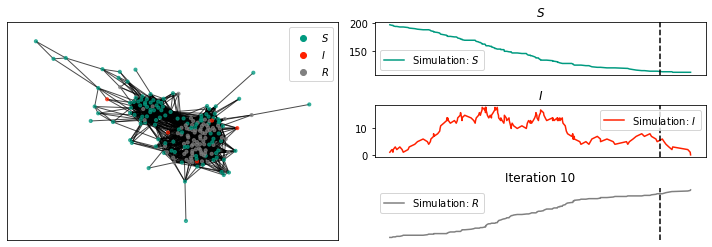

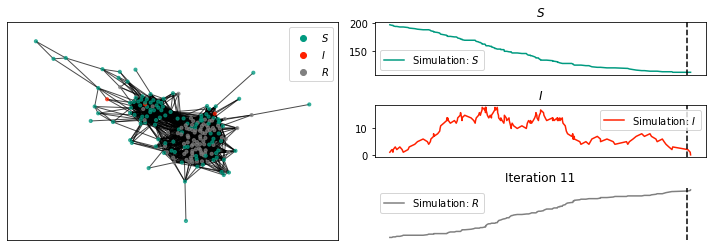

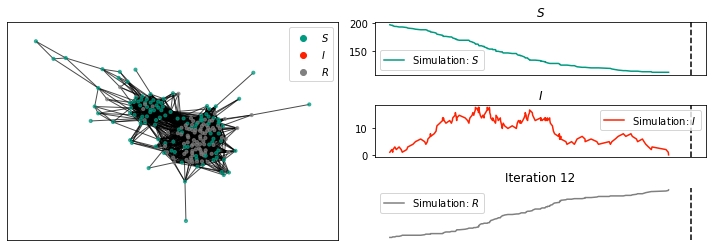

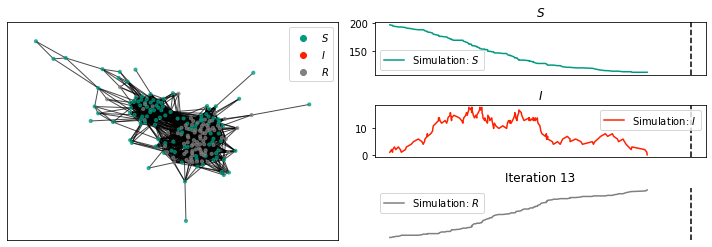

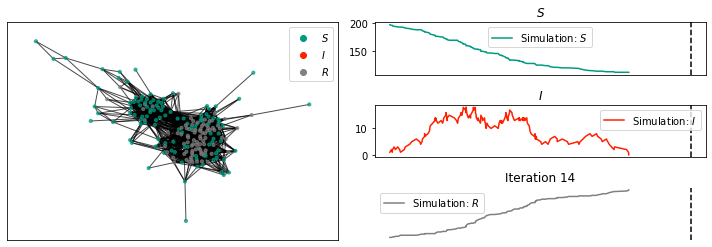

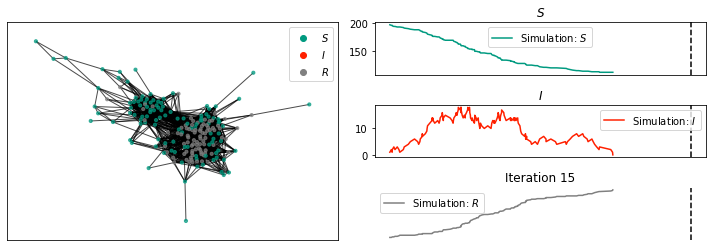

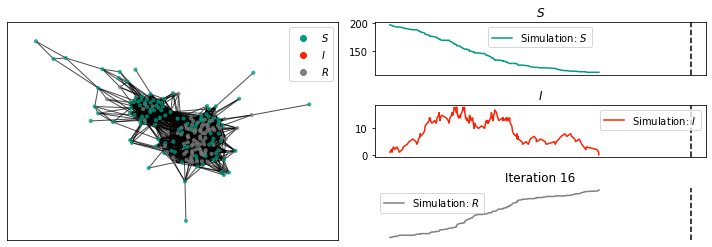

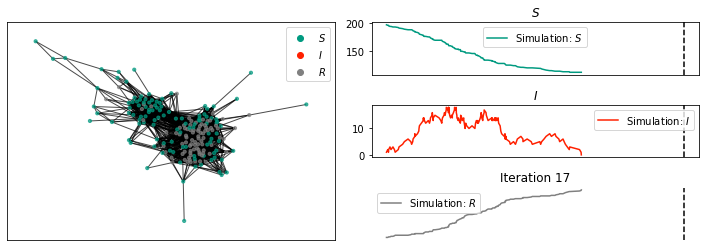

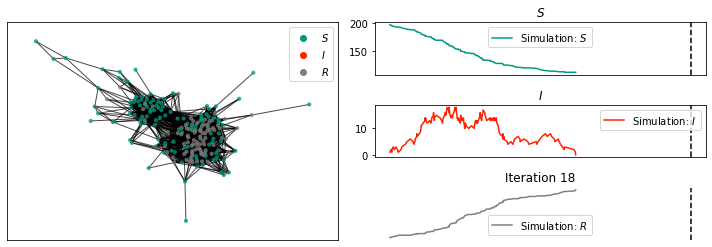

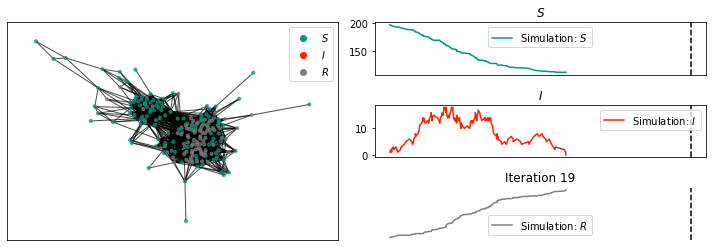

In [ ]:
g = graph_jazz_collab
tmax = 20
tau = 0.05           #transmission rate
gamma = 1.0    #recovery rate

#nx_kwargs = {"with_labels":True} #optional arguments to be passed on to the #networkx plotting command.
pos = nx.spring_layout(g)
nx_kwargs = {"pos": pos, "alpha": 0.7, "node_size": 10}
print('doing Gillespie simulation')
sim = EoN.Gillespie_SIR(g, tau, gamma, return_full_data=True, tmax=tmax)
print('done with simulation, now plotting')
for i in range(0, tmax, 1):
    sim.display(time = i,  **nx_kwargs)
    plt.axis('off') 
    plt.title("Iteration {}".format(i))
    plt.draw()

In [ ]:
import EoN
#
gamma = 0.2  
# 
beta = 1.2 
r_0 = beta/gamma
print(r_0)
N = 100 # population size
I0 = 1   # intial n° of infected individuals 
R0 = 0
S0 = N - I0 -R0
pos = nx.spring_layout(g)
nx_kwargs = {"pos": pos, "alpha": 0.7} #optional arguments to be passed on to the
#x_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.
print("doing Gillespie simulation")
sim = EoN.Gillespie_SIR(g, tau = beta, gamma=gamma, rho = I0/N, transmission_weight="weight", return_full_data=True)
print("done with simulation, now plotting")
for i in range(0,10,1):
    sim.display(time = i,  **nx_kwargs)
    plt.axis('off') 
    plt.title("Iteration {}".format(i))
    plt.draw()

doing Gillespie simulation
done with simulation, now plotting


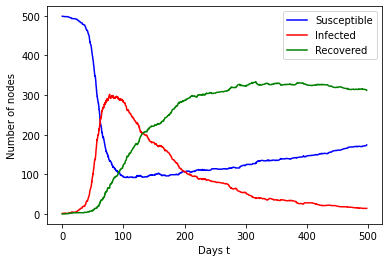

In [ ]:
# Source: https://stackoverflow.com/questions/65378617/sirs-model-with-agents-on-networkx

import networkx as nx
import matplotlib.pyplot as plt 
import EoN
from collections import defaultdict

# parameters required for the SIRS model
a = 0.1
b = 0.01
y = 0.001
d = 0.001

# Simple contagions
# the below is based on an example of a SEIR disease (there is an exposed state before becoming infectious)
# from https://arxiv.org/pdf/2001.02436.pdf

Gnp = nx.gnp_random_graph(500, 0.005)

H = nx.DiGraph() #For the spontaneous transitions
H.add_edge('I', 'R', rate = b)  # an infected node can be recovered/removed
H.add_edge('I', 'S', rate = y)  # an infected node can become susceptible again
H.add_edge('R', 'S', rate = d)  # a recovered node can become suscepticle again

J = nx.DiGraph() #for the induced transitions
J.add_edge(('I', 'S'),('I', 'I'), rate = a)  # a susceptible node can become infected from a neighbour
IC = defaultdict(lambda: 'S')

# set all statuses except one to susceptible. only one node shall begin infected
for node in range(500):
    IC[node] = 'S'
IC[0] = 'I'

return_statuses = ('S', 'I', 'R')
print('doing Gillespie simulation')

t, S, I, R = EoN.Gillespie_simple_contagion(Gnp, H, J, IC, return_statuses, tmax = 500)

print('done with simulation, now plotting')
plt.plot(t, S, label = 'Susceptible', color="b")
plt.plot(t, I, label = 'Infected', color="r")
plt.plot(t, R, label = 'Recovered', color="g")
#plt.plot(t, R+I, label = 'Non Susceptible', color="y")

plt.xlabel('Days t')
plt.ylabel('Number of nodes')
plt.legend()
plt.show()

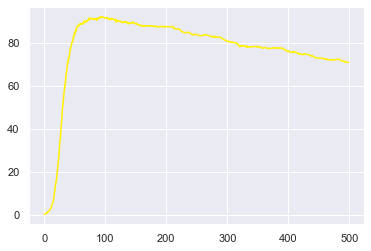

In [ ]:
H = 0.21*(R + I) # Cumulative hospitalized patients

plt.plot(t, H, label = 'Hospitalized', color="")

## 3.2 Weighted Networks

(-1.152856730232391,
 0.9326932622745292,
 -1.0199274957481652,
 1.1919388118131742)

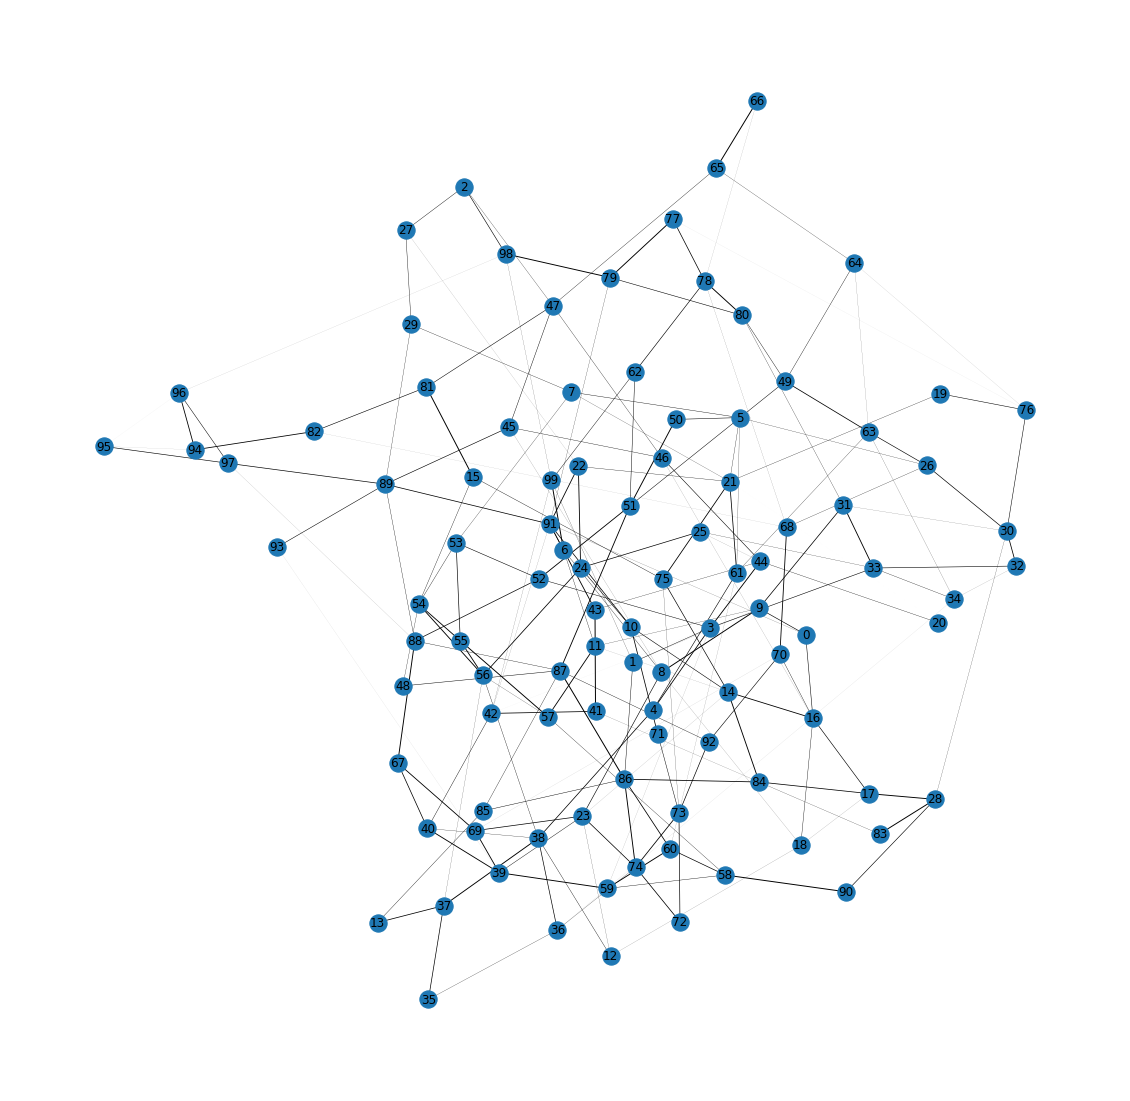

In [ ]:
import random
E = g.number_of_edges()
#initializing random weights
w = [random.random() for i in range(E)]
s = max(w)
w = [ i/s for i in w ] #normalizing
len(w)
k = 0
for i, j in g.edges():
    g[i][j]['weight'] = w[k]
    k+=1
edgewidth = [d['weight'] for (u,v,d) in g.edges(data=True)]
# layout
#pos = nx.spring_layout(G, iterations=50)
pos = nx.spring_layout(g)
labels = {}
for i in range(100):
    labels[i] = i
# rendering
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos, width=edgewidth, node_size=500)
nx.draw_networkx_labels(g, pos, labels)
plt.axis('off')

5.999999999999999
doing Gillespie simulation
done with simulation, now plotting


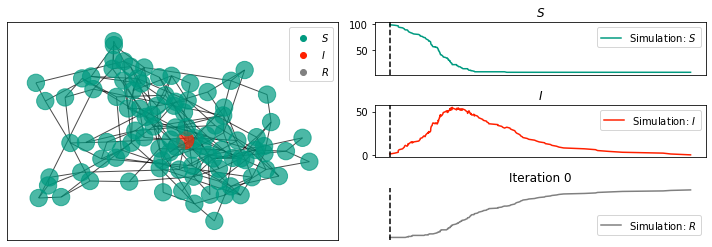

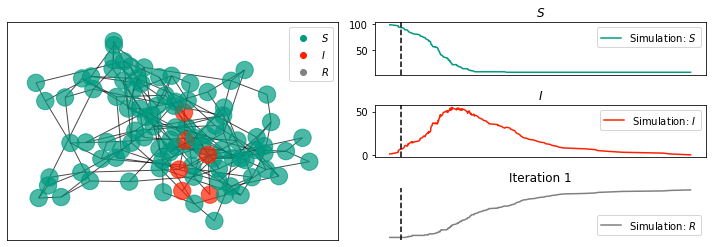

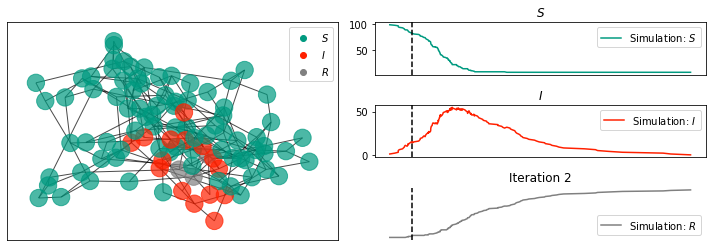

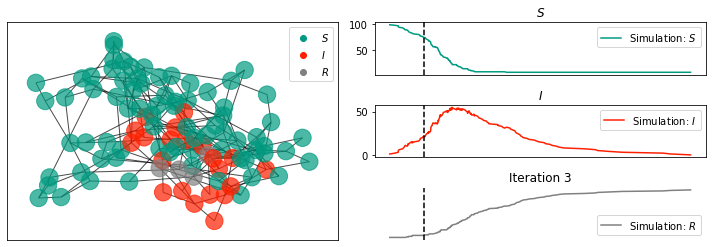

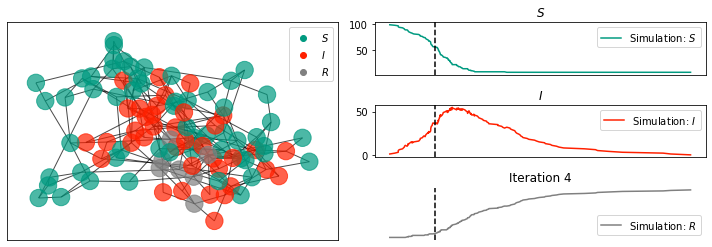

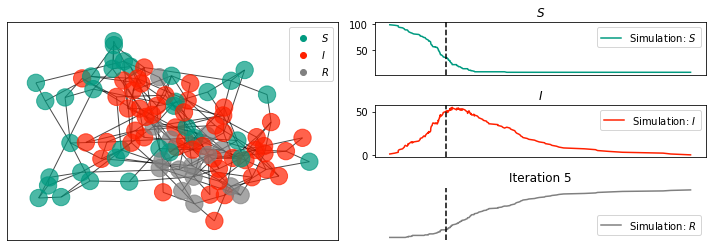

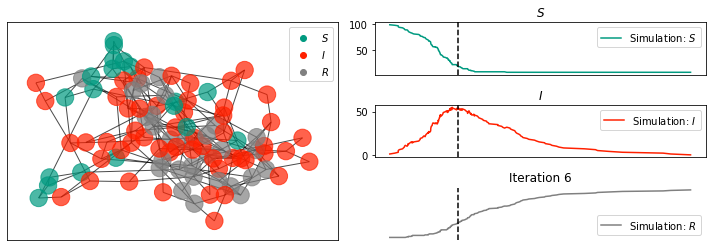

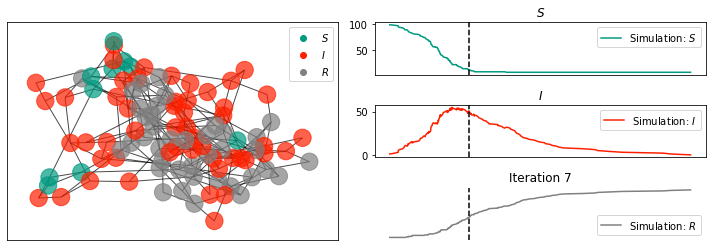

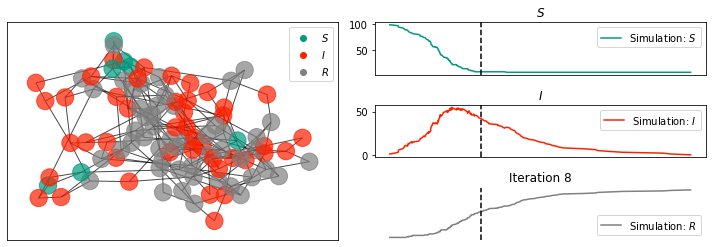

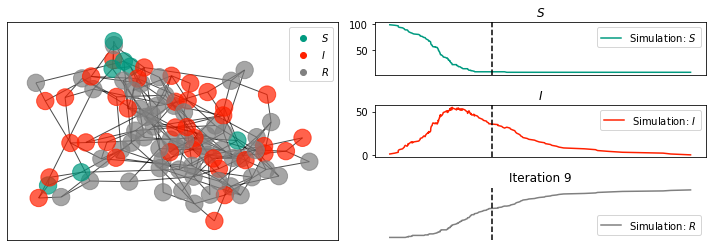

In [ ]:
gamma = 0.2  
beta = 1.2 
r_0 = beta/gamma
print(r_0)
N = 100 # population size
I0 = 1   # intial n° of infected individuals 
R0 = 0
S0 = N - I0 -R0
pos = nx.spring_layout(g)
nx_kwargs = {"pos": pos, "alpha": 0.7} #optional arguments to be passed on to the
#x_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.
print("doing Gillespie simulation")
sim = EoN.Gillespie_SIR(g, tau = beta, gamma=gamma, rho = I0/N, transmission_weight="weight", return_full_data=True)
print("done with simulation, now plotting")
for i in range(0,10,1):
    sim.display(time = i,  **nx_kwargs)
    plt.axis('off') 
    plt.title("Iteration {}".format(i))
    plt.draw()

generating graph G with 100000 nodes
doing Event-driven simulation
doing Gillespie simulation
done with simulations, now plotting


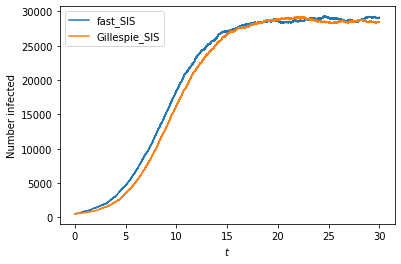

In [ ]:
N = 10**5 #number of individuals
kave = 5 #expected number of partners
print('generating graph G with {} nodes'.format(N))
G = nx.fast_gnp_random_graph(N, kave/(N-1)) #Erdo''s-Re'nyi graph
rho = 0.005 #initial fraction infected
tau = 0.3 #transmission rate
gamma = 1.0 #recovery rate
print('doing Event-driven simulation')
t1, S1, I1 = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax = 30) 
print('doing Gillespie simulation')
t2, S2, I2 = EoN.Gillespie_SIS(G, tau, gamma, rho=rho, tmax = 30)
print('done with simulations, now plotting')
plt.plot(t1, I1, label = 'fast_SIS')
plt.plot(t2, I2, label = 'Gillespie_SIS')
plt.xlabel('$t$')
plt.ylabel('Number infected')
plt.legend()
plt.show()

generating graph G with 1000000 nodes
0
doing Event-driven simulation
done with simulation, now plotting
1
doing Event-driven simulation
done with simulation, now plotting
2
doing Event-driven simulation
done with simulation, now plotting
3
doing Event-driven simulation
done with simulation, now plotting
4
doing Event-driven simulation
done with simulation, now plotting
5
doing Event-driven simulation
done with simulation, now plotting
6
doing Event-driven simulation
done with simulation, now plotting
7
doing Event-driven simulation
done with simulation, now plotting
8
doing Event-driven simulation
done with simulation, now plotting
9
doing Event-driven simulation
done with simulation, now plotting


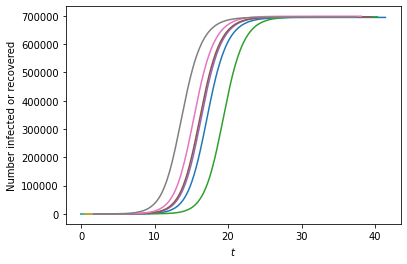

In [ ]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import numpy as np
def rec_time_fxn_gamma(u):
    return np.random.gamma(3, 0.5) #gamma distributed random number

def trans_time_fxn(u, v, tau):
    if tau >0:
        return np.random.exponential(1./tau)
    else:
        return float('Inf')
N = 10**6 #number of individuals
kave = 5 #expected number of partners
print('generating graph G with {} nodes'.format(N))
G = nx.fast_gnp_random_graph(N, kave/(N-1)) #Erdo''s-Re'nyi graph tau = 0.3
for cntr in range(10):
    print(cntr)
    print('doing Event-driven simulation')
    t, S, I, R = EoN.fast_nonMarkov_SIR(G, trans_time_fxn = trans_time_fxn,
                                        rec_time_fxn = rec_time_fxn_gamma,
                                        trans_time_args = (tau,))
    #To reduce file size and make plotting faster, we'll just plot 1000
    #data points.  It's not really needed here, but this demonstrates
    #one of the available tools in EoN.
    subsampled_ts = np.linspace(t[0], t[-1], 1000)
    subI, subR = EoN.subsample(subsampled_ts, t, I, R)
    print('done with simulation, now plotting')
    plt.plot(subsampled_ts, subI+subR)
plt.xlabel('$t$')
plt.ylabel('Number infected or recovered')
plt.show()

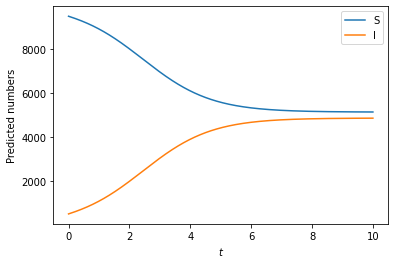

In [ ]:
import networkx as nx
import EoN
7
import matplotlib.pyplot as plt
N=10000
gamma = 1
rho = 0.05
kave = 20
tau = 2*gamma/ kave
S0 = (1-rho)*N
I0 = rho*N
SI0 = (1-rho)*kave*rho*N
SS0 = (1-rho)*kave*(1-rho)*N
t, S, I = EoN.SIS_homogeneous_pairwise(S0, I0, SI0, SS0, kave, tau, gamma,
tmax=10)
plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.xlabel('$t$')
plt.ylabel('Predicted numbers')
plt.legend()
plt.show()

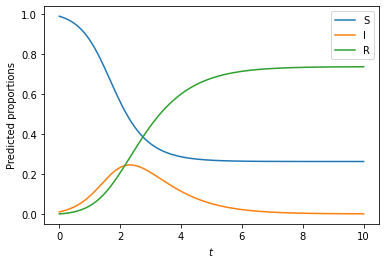

In [ ]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import numpy as np
gamma = 1
tau = 1.5
kave = 3
rho = 0.01
phiS0 = 1-rho
def psi(x):
    return (1-rho)* np.exp(-kave*(1-x))
def psiPrime(x):
    return (1-rho)*kave*np.exp(-kave*(1-x))
N=1
t, S, I, R = EoN.EBCM(N, psi, psiPrime, tau, gamma, phiS0, tmax = 10)
plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.plot(t, R, label = 'R')
plt.xlabel('$t$')
plt.ylabel('Predicted proportions')
plt.legend()
plt.show()

doing Gillespie simulation
done with simulation, now plotting


(<AxesSubplot:>,
 [<AxesSubplot:title={'center':'$S$'}>,
  <AxesSubplot:title={'center':'$I$'}>,
  <AxesSubplot:title={'center':'$R$'}, xlabel='$t$'>])

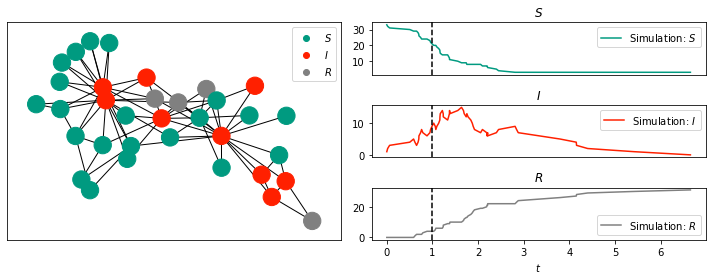

In [ ]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
G = nx.karate_club_graph()
nx_kwargs = {"with_labels":True} #optional arguments to be passed on to the #networkx plotting command.
print('doing Gillespie simulation')
sim = EoN.Gillespie_SIR(G, 1, 1, return_full_data=True)
print('done with simulation, now plotting')
sim.display(time = 1) #plot at time 1. plt.show()

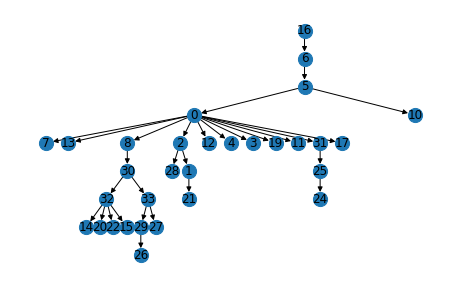

In [ ]:
T = sim.transmission_tree() #A networkx DiGraph with the transmission tree 
Tpos = EoN.hierarchy_pos(T) #pos for a networkx plot
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)
nx.draw(T, Tpos, ax=ax, node_size = 200, with_labels=True)
plt.show()

generating graph Gc
doing Gillespie simulation


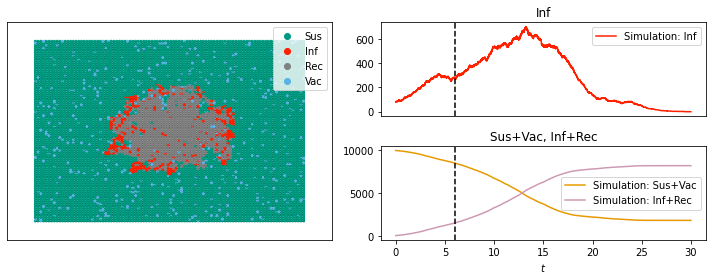

In [ ]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
from collections import defaultdict
print('generating graph Gc')
G = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99 #we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 45<u<55 and 45<v<55]
H = nx.DiGraph() #the spontaneous transitions 
H.add_edge('Sus', 'Vac', rate = 0.01)
H.add_edge('Vac', 'Sus', rate = 0.05) 
H.add_edge('Inf', 'Rec', rate = 1.0)
J = nx.DiGraph() #the induced transitions 
J.add_edge(('Inf', 'Sus'), ('Inf', 'Inf'), rate = 2.0)
#23
#The command hierarchy pos is based on [15].
#Example - Visualizing dynamics of SIR disease with vaccination.
IC = defaultdict(lambda:'Sus') #a "dict", but by default the value is \texttt{'Sus'}. 
for node in initial_infections:
    IC[node] = 'Inf'
    
return_statuses = ['Sus', 'Inf', 'Rec', 'Vac']
color_dict = {'Sus': '#009a80','Inf':'#ff2000', 'Rec':'gray','Vac': '#5AB3E6'}
pos = {node:node for node in G}
tex = False
sim_kwargs = {'color_dict':color_dict, 'pos':pos, 'tex':tex}
print('doing Gillespie simulation')
sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=30, return_full_data=True, sim_kwargs=sim_kwargs)
times, D = sim.summary()
#
#times is a numpy array of times. D is a dict, whose keys are the entries in #return_statuses. The values are numpy arrays giving the number in that #status at the corresponding time.
newD = {'Sus+Vac':D['Sus']+D['Vac'], 'Inf+Rec' : D['Inf'] + D['Rec']}
#
#newD is a new dict giving number not yet infected or the number ever infected #Let's add this timeseries to the simulation.
#
new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = 'Simulation',
                    color_dict={'Sus+Vac':'#E69A00', 'Inf+Rec':'#CD9AB3'})
sim.display(time=6, node_size = 4, ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']])
plt.show()

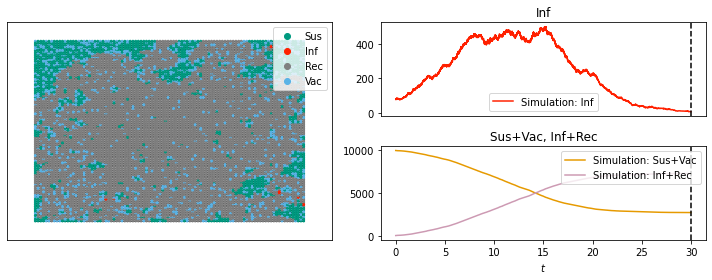

In [ ]:
ani=sim.animate(ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']], node_size = 4)
ani.save('SIRV_animate.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

In [ ]:
import EoN
import networkx as nx
from matplotlib import rc
import matplotlib.pylab as plt


import scipy
import random



colors = ['#5AB3E6','#FF2000','#009A80','#E69A00', '#CD9AB3', '#0073B3',
        '#F0E442']

#commands to make legend be in LaTeX font
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



rho = 0.025
target_k = 6
N=10000
tau = 0.5
gamma = 1.
ts = scipy.arange(0,40,0.05)
count = 50 #number of simulations to run for each



def generate_network(Pk, N, ntries = 100):
    r'''Generates an N-node random network whose degree distribution is given by Pk'''
    counter = 0
    while counter< ntries:
        counter += 1
        ks = []
        for ctr in range(N):
            ks.append(Pk())
        if sum(ks)%2 == 0:
            break
    if sum(ks)%2 ==1:
        raise EoN.EoNError("cannot generate even degree sum")
    G = nx.configuration_model(ks)
    return G



#An erdos-renyi network has a Poisson degree distribution.
def PkPoisson():
    return scipy.random.poisson(target_k)
def PsiPoisson(x):
    return scipy.exp(-target_k*(1-x))
def DPsiPoisson(x):
    return target_k*scipy.exp(-target_k*(1-x))



#a regular (homogeneous) network has a simple generating function.

def PkHomogeneous():
    return target_k
def PsiHomogeneous(x):
    return x**target_k
def DPsiHomogeneous(x):
    return target_k*x**(target_k-1)




#The following 30 - 40 lines or so are devoted to defining the degree distribution
#and the generating function of the truncated power law network.

#defining the power law degree distribution here:
assert(target_k==6) #if you've changed target_k, then you'll
                #want to update the range 1..61 and/or
                #the exponent 1.5.

PlPk = {}
exponent = 1.5
kave = 0
for k in range(1,61):
    PlPk[k]=k**(-exponent)
    kave += k*PlPk[k]

normfactor= sum(PlPk.values())
for k in PlPk:
    PlPk[k] /= normfactor

def PkPowLaw():
    r = random.random()
    for k in PlPk:
        r -= PlPk[k]
        if r<0:
            return k

def PsiPowLaw(x):
    #print PlPk
    rval = 0
    for k in PlPk:
        rval += PlPk[k]*x**k
    return rval

def DPsiPowLaw(x):
    rval = 0
    for k in PlPk:
        rval += k*PlPk[k]*x**(k-1)
    return rval
#End of power law network properties.





def process_degree_distribution(N, Pk, color, Psi, DPsi, symbol, label, count):
    report_times = scipy.linspace(0,30,3000)
    sums = 0*report_times
    for cnt in range(count):
        G = generate_network(Pk, N)
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho)
        plt.plot(t, I*1./N, '-', color = color,
                                alpha = 0.1, linewidth=1)
        subsampled_I = EoN.subsample(report_times, t, I)
        sums += subsampled_I*1./N
    ave = sums/count
    plt.plot(report_times, ave, color = 'k')

    #Do EBCM
    N= G.order()#N is arbitrary, but included because our implementation of EBCM assumes N is given.
    t, S, I, R = EoN.EBCM_uniform_introduction(N, Psi, DPsi, tau, gamma, rho, tmin=0, tmax=10, tcount = 41)
    plt.plot(t, I/N, symbol, color = color, markeredgecolor='k', label=label)

    for cnt in range(3):  #do 3 highlighted simulations
        G = generate_network(Pk, N)
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho)
        plt.plot(t, I*1./N, '-', color = 'k', linewidth=0.1)




plt.figure(figsize=(8,4))



#Powerlaw
process_degree_distribution(N, PkPowLaw, colors[3], PsiPowLaw, DPsiPowLaw, 'd', r'Truncated Power Law', count)

#Poisson
process_degree_distribution(N, PkPoisson, colors[0], PsiPoisson, DPsiPoisson, '^', r'Erd\H{o}s--R\'{e}nyi', count)

#Homogeneous
process_degree_distribution(N, PkHomogeneous, colors[2], PsiHomogeneous, DPsiHomogeneous, 's', r'Homogeneous', count)

plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'Proportion infected', fontsize=12)
plt.legend(loc = 'upper right', numpoints = 1)

plt.axis(xmax=10, xmin=0, ymin=0)
plt.savefig('fig1p2.pdf')

ModuleNotFoundError: ignored

## OpenData

In [ ]:
dataset_url = "https://www.covid19.admin.ch/api/data/20211027-weppzp5n/sources/COVID19VaccDosesAdministered_indication_w.json"
import urllib.request, json 
with urllib.request.urlopen(dataset_url) as url:
    data = json.loads(url.read().decode())
    print(data)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
jsonurl = urllib.request.urlopen(dataset_url)
observations = json.loads(jsonurl.read())

In [ ]:
print(len(text))

10208


In [ ]:
print(type(text))

<class 'list'>


In [ ]:
print(text[100])

{'date': 202111, 'geoRegion': 'AG', 'indication': 'med_prof', 'entries': 1942, 'type_variant': 'indication', 'pop': 694072, 'sumTotal': 16194, 'freq': 0.184, 'prct': 18.4, 'prctSumTotal': 16.4, 'per100Persons': 0.28, 'per100PersonsTotal': 2.33, 'type': 'COVID19VaccDosesAdministered', 'version': '2021-10-27_08-03-17', 'granularity': 'detailed'}


In [ ]:
for observation in observations:
    print(observation['geoRegion'])

IndentationError: expected an indented block (705750604.py, line 1)

In [ ]:
daily_cases_url = "https://www.covid19.admin.ch/api/data/20211027-weppzp5n/sources/COVID19Cases_geoRegion_w.json"

In [ ]:
jsonurl = urllib.request.urlopen(daily_cases_url)
observations = json.loads(jsonurl.read())

import pandas as pd

df = pd.json_normalize(observations)
#print (df)
print(len(df))
df.head(5)

3132


,geoRegion,datum,entries,timeframe_all,timeframe_phase2,timeframe_phase2b,timeframe_phase3,timeframe_phase4,timeframe_vacc_info,timeframe_28d,...,inzsumTotal,type,type_variant,version,datum_unit,datum_dboardformated,entries_diff_abs,entries_diff_inz,entries_diff_pct,prct_diff
0,CH,202009,56,True,False,False,False,False,False,False,...,0.65,COVID19Cases,,2021-10-27_07-51-17,isoweek,2020-09,NaN,NaN,NaN,NaN
1,CH,202010,377,True,False,False,False,False,False,False,...,4.99,COVID19Cases,,2021-10-27_07-51-17,isoweek,2020-10,321.0,3.70,573.2,0.0
2,CH,202011,2265,True,False,False,False,False,False,False,...,31.12,COVID19Cases,,2021-10-27_07-51-17,isoweek,2020-11,1888.0,21.77,500.8,0.0
3,CH,202012,6559,True,False,False,False,False,False,False,...,106.77,COVID19Cases,,2021-10-27_07-51-17,isoweek,2020-12,4294.0,49.53,189.6,0.0
4,CH,202013,7346,True,False,False,False,False,False,False,...,191.49,COVID19Cases,,2021-10-27_07-51-17,isoweek,2020-13,787.0,9.08,12.0,0.0


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx.algorithms.community as nxcom

In [ ]:
def quantify_graph(graph):
    number_of_nodes = graph.number_of_nodes()
    print("The graph has {} nodes and {} edges".format(number_of_nodes, number_of_edges))
    
    print("graph exploration")
    print(nx.is_weighted(graph))

In [ ]:
def visualize_graph(graph):
    

In [ ]:
def load_graph(graph_name):
    

In [ ]:
facebook_graph = nx.read_gml("data/graph_facebook.gml")

In [ ]:
quantify_graph(facebook_graph)

The graph has 4039 nodes
graph exploration
False


In [ ]:
facebook_graph.number_of_nodes()

4039

In [ ]:
facebook_graph.number_of_edges()

88234

In [ ]:
def draw_communities(gr, greedy=True, node_size=100, gr_name='', randomized=False):
  if greedy:
    coms = nxcom.greedy_modularity_communities(gr)
  else:
    coms = list(nxcom.label_propagation_communities(gr))
    
  color_dict = {}
  for com in coms:
    color = tuple([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    for item in com:
      color_dict[item] = color
  colors = []
  for node in gr.nodes():
    colors.append(color_dict[node])

  plt.title(f"{'Randomized' if randomized else ''} {gr_name} Network: {len(coms)} {'greedy modular' if greedy else 'label propagation'} communities")
  nx.draw(gr, pos=nx.spring_layout(gr), node_color=colors, node_size=node_size)
  plt.show()

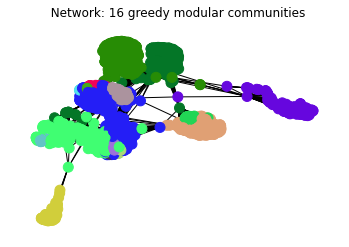

In [ ]:
draw_communities(facebook_graph)

In [ ]:
draw_communities(facebook_graph)